In [1]:
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import tensorflow as tf
%matplotlib inline
from sklearn.metrics import confusion_matrix
from tensorflow.contrib.timeseries.python.timeseries import NumpyReader
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Flatten
from keras.layers import LSTM
import os

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing   
from sklearn.preprocessing import MinMaxScaler

from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D



Using TensorFlow backend.


In [2]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    dataset=dataset.tolist()
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

def split_dataset(data):
	predict_index=1      # the test data need to be two years!!!   
	# split into standard weeks
	train, test = data[0:len(data)-12*predict_index], data[len(data)-12*predict_index::]
	# restructure into windows of montyly data
	train = np.array(np.split(train, len(train)/12))
	test = np.array(np.split(test, len(test)/12))
	return train, test

In [3]:
def to_supervised(train, n_input, n_out):
	# flatten data
	data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
	X, y = list(), list()
	in_start = 0
	# step over the entire history one time step at a time
	for _ in range(len(data)):
		# define the end of the input sequence
		in_end = in_start + n_input
		out_end = in_end + n_out
		# ensure we have enough data for this instance
		if out_end < len(data):
			x_input = data[in_start:in_end, 0]
			x_input = x_input.reshape((len(x_input), 1))
			X.append(x_input)
			y.append(data[in_end:out_end, 0])
		# move along one time step
		in_start += 1
	return np.array(X), np.array(y)

In [4]:
def build_model(train_x,train_y,n_input,n_out,  n_steps, n_length):
	# define parameters
	verbose, epochs, batch_size = 2,200,32
	n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
	# reshape output into [samples, timesteps, features]
	train_x = train_x.reshape((train_x.shape[0], n_steps,1, n_length, n_features))
	train_y = train_y.reshape((train_y.shape[0], train_y.shape[1],1))
	# define model

	model = Sequential()
	model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
	model.add(Flatten())
	model.add(RepeatVector(n_outputs))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(LSTM(256, activation='linear', return_sequences=True))
	model.add(TimeDistributed(Dense(100, activation='linear')))
	model.add(TimeDistributed(Dense(1)))
	model.compile(loss='mse', optimizer='adam')
	model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
	# fit network
	return model


In [5]:
# make a forecast
def forecast(model, history, n_input, n_steps, n_length):
	# flatten data
	data = np.array(history)
	data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
	print (data.shape)
	# retrieve last observations for input data
	input_x = data[-n_input:, 0]
	# reshape into [1, n_input, 1]
	input_x = input_x.reshape((1, n_steps,1,n_length, 1))
	# forecast the next week
	yhat = model.predict(input_x, verbose=0)

	# we only want the vector forecast
	yhat = yhat[0]
	return yhat

# evaluate a single model
def evaluate_model(train, test, n_input,n_steps, n_length):
	# fit model
#	model = build_model(train, n_input)
	# history is a list of weekly data
	history = [x for x in train]
	print (len(history))
	print (history[0])
	#print (len(test))
	# walk-forward validation over each week
	predictions = list()
	for i in range(len(test)):
		# predict the week
		yhat_sequence = forecast(model, history, n_input,n_steps, n_length)
		print ("the prediction values are:{0}".format(yhat_sequence))
		print ("the real values are:{0}".format(test[i, :, 0]))
		# store the predictions
		predictions.append(yhat_sequence)
		# get real observation and add to history for predicting the next week
		history.append(test[i, :])
	# evaluate predictions days for each week
	predictions = np.array(predictions)
	score, scores = evaluate_forecasts(test[:, :, 0], predictions) 
	return score, scores,predictions

# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
	scores = list()
	# calculate an RMSE score for each day
	for i in range(actual.shape[1]):
		# calculate mse
		print (actual.shape[1])
		mse = mean_squared_error(actual[:, i], predicted[:, i])
		print (actual[:, i])
		print (predicted[:, i])
		print (mse)
		# calculate rmse
		rmse = np.sqrt(mse)
		# store
		scores.append(rmse)
    
	# calculate overall RMSE
	s = 0
	for row in range(actual.shape[0]):
		for col in range(actual.shape[1]):
			s += (actual[row, col] - predicted[row, col])**2
	score = np.sqrt(s / (actual.shape[0] * actual.shape[1]))
	return score, scores

# summarize scores
def summarize_scores(name, score, scores):
	s_scores = ', '.join(['%.1f' % s for s in scores])
	print('%s: [%.3f] %s' % (name, score, s_scores))

# convert history into inputs and outputs

In [6]:
real_in_one=[]
prediction_in_one=[]
train_prediciton_in_one=[]
dataset_in_one=[]
signals=[]
all_signals=[]
file_name="ONI"
with open("{0}.txt".format(file_name)) as file:
    for lines in  file:
        every_signal=[]
        line=lines.split(",")
        for element in line:
            every_signal.append(float(element))
        all_signals.append(every_signal)
        signals.append(every_signal)

data={}
pd_date=pd.date_range('1/1/1950','12/1/2018',freq='MS')
data["date"]=pd_date

for i in range(len(signals)):
    index="f"+str(i)
    data[index]=signals[i]


df=pd.DataFrame(data)
df.to_csv("{0}_data.txt".format(file_name))

print (df.shape)

if(os.path.exists('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD')

(828, 10)


0     -0.025547
1      0.092241
2      0.091614
3     -0.029861
4     -0.081061
5     -0.081246
6      0.075370
7     -0.018363
8     -0.065202
9      0.064017
10     0.035250
11    -0.054299
12    -0.080261
13     0.032733
14     0.039559
15     0.112890
16     0.014132
17    -0.040457
18    -0.143370
19    -0.080158
20    -0.046180
21     0.160100
22     0.036908
23    -0.030857
24    -0.161610
25    -0.074868
26     0.005449
27     0.152760
28     0.140540
29    -0.030355
         ...   
666   -0.109810
667    0.001179
668    0.131850
669    0.084394
670   -0.067759
671   -0.158370
672   -0.115690
673   -0.044805
674    0.059464
675    0.103470
676    0.193580
677   -0.056176
678   -0.202890
679   -0.208760
680   -0.158770
681   -0.044196
682    0.143450
683    0.209620
684    0.145020
685   -0.073161
686   -0.170330
687   -0.170350
688   -0.084327
689    0.003465
690    0.113130
691    0.056119
692    0.011284
693   -0.050664
694    0.034800
695    0.017427
Name: f0, Length: 696, d

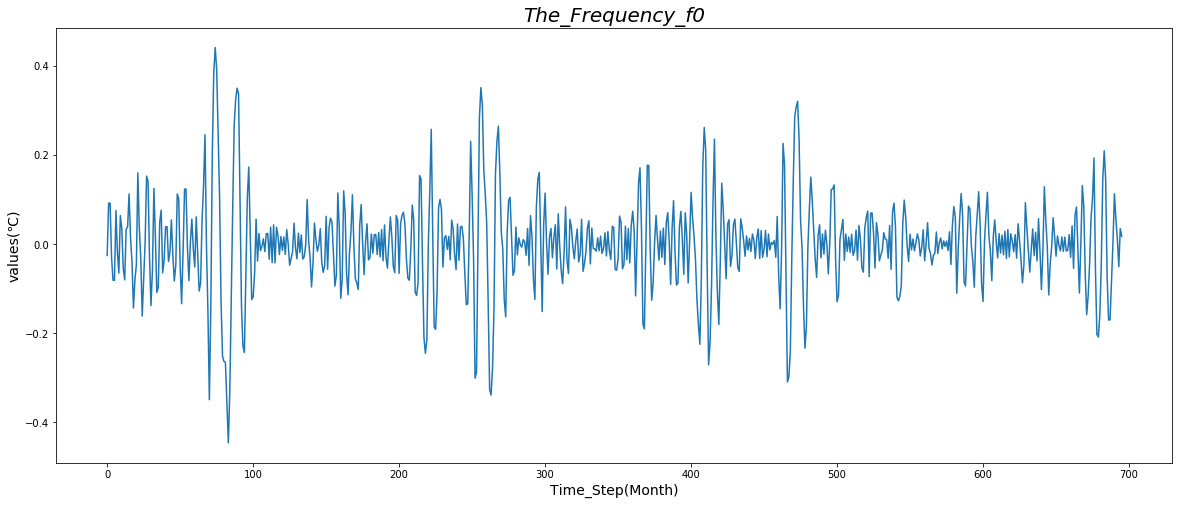

[[[-2.5547e-02]
  [ 9.2241e-02]
  [ 9.1614e-02]
  [-2.9861e-02]
  [-8.1061e-02]
  [-8.1246e-02]
  [ 7.5370e-02]
  [-1.8363e-02]
  [-6.5202e-02]
  [ 6.4017e-02]
  [ 3.5250e-02]
  [-5.4299e-02]]

 [[-8.0261e-02]
  [ 3.2733e-02]
  [ 3.9559e-02]
  [ 1.1289e-01]
  [ 1.4132e-02]
  [-4.0457e-02]
  [-1.4337e-01]
  [-8.0158e-02]
  [-4.6180e-02]
  [ 1.6010e-01]
  [ 3.6908e-02]
  [-3.0857e-02]]

 [[-1.6161e-01]
  [-7.4868e-02]
  [ 5.4492e-03]
  [ 1.5276e-01]
  [ 1.4054e-01]
  [-3.0355e-02]
  [-1.3808e-01]
  [-5.8738e-02]
  [ 1.2519e-01]
  [ 1.9747e-02]
  [-1.0855e-01]
  [-9.7296e-02]]

 [[ 4.9602e-02]
  [ 7.6171e-02]
  [-6.4388e-02]
  [-3.7326e-02]
  [ 3.8834e-02]
  [ 3.9240e-02]
  [-3.9069e-02]
  [-1.8257e-02]
  [ 5.4259e-02]
  [-2.5882e-02]
  [-8.3007e-02]
  [-4.7521e-02]]

 [[ 1.1258e-01]
  [ 1.0203e-01]
  [-5.0122e-02]
  [-1.3377e-01]
  [-1.6454e-02]
  [ 1.2364e-01]
  [ 1.2345e-01]
  [-1.0158e-02]
  [-8.2005e-02]
  [ 4.5278e-03]
  [ 5.6274e-02]
  [-1.0434e-02]]

 [[-5.1485e-02]
  [ 6.1355e-02

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
 - 5s - loss: 0.0109
Epoch 2/200
 - 1s - loss: 0.0108
Epoch 3/200
 - 1s - loss: 0.0108
Epoch 4/200
 - 1s - loss: 0.0108
Epoch 5/200
 - 1s - loss: 0.0108
Epoch 6/200
 - 1s - loss: 0.0108
Epoch 7/200
 - 1s - loss: 0.0108
Epoch 8/200
 - 1s - loss: 0.0107
Epoch 9/200
 - 1s - loss: 0.0107
Epoch 10/200
 - 1s - loss: 0.0106
Epoch 11/200
 - 1s - loss: 0.0105
Epoch 12/200
 - 1s - loss: 0.0103
Epoch 13/200
 - 1s - loss: 0.0102
Epoch 14/200
 - 1s - loss: 0.0101
Epoch 15/200
 - 1s - loss: 0.0096
Epoch 16/200
 - 1s - loss: 0.0095
Epoch 17/200
 - 1s - loss: 0.0092
Epoch 18/200
 - 1s - loss: 0.0091
Epoch 19/200
 - 1s - loss: 0.0089
Epoch 20/200
 - 1s - loss: 0.0087
Epoch 21/200
 - 1s - loss: 0.0086
Epoch 22/200
 - 1s - loss: 0.0086
Epoch 23/200
 - 1s - loss: 0.0083
Epoch 24/200
 - 1s - loss: 0.0083
Epoch 25/200
 - 1s - loss: 0.0082
Epoch 26/200
 - 1s - loss: 0.0089
Epoch 27/200
 - 2s - loss: 0.0082
Epoch 28/200
 - 1s - loss: 0.0082
Epoch 29/

(55, 12)


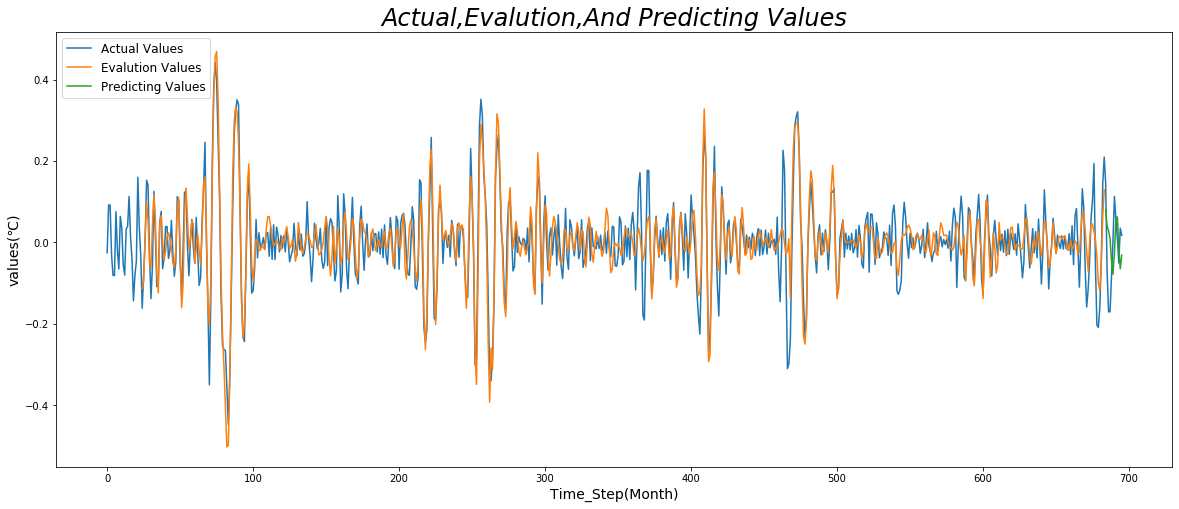

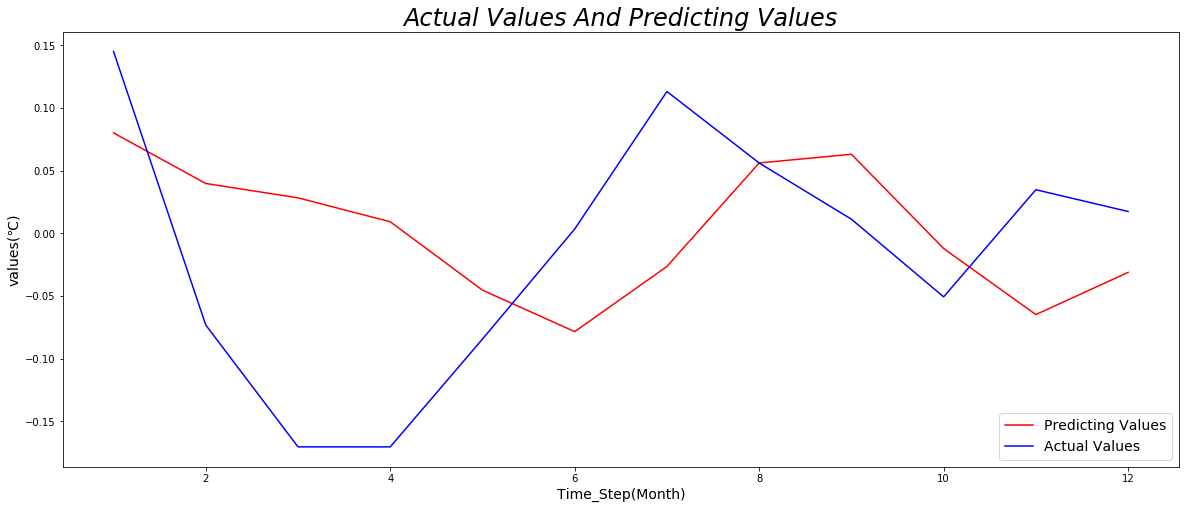

0     -0.294540
1     -0.206260
2     -0.114940
3     -0.018285
4      0.092434
5      0.236340
6      0.407510
7      0.512940
8      0.455400
9      0.206520
10    -0.097637
11    -0.351990
12    -0.478850
13    -0.451500
14    -0.319580
15    -0.149650
16     0.002985
17     0.128160
18     0.224470
19     0.283560
20     0.306910
21     0.296920
22     0.250800
23     0.176900
24     0.086898
25    -0.006406
26    -0.085830
27    -0.131520
28    -0.123820
29    -0.071080
         ...   
666    0.085599
667    0.017406
668   -0.078700
669   -0.206180
670   -0.339740
671   -0.446900
672   -0.500660
673   -0.496410
674   -0.436530
675   -0.323780
676   -0.160910
677    0.041635
678    0.244560
679    0.413660
680    0.537540
681    0.611040
682    0.629310
683    0.589520
684    0.499680
685    0.379930
686    0.252980
687    0.139920
688    0.049156
689   -0.037781
690   -0.143730
691   -0.282870
692   -0.436790
693   -0.578930
694   -0.676550
695   -0.682130
Name: f1, Length: 696, d

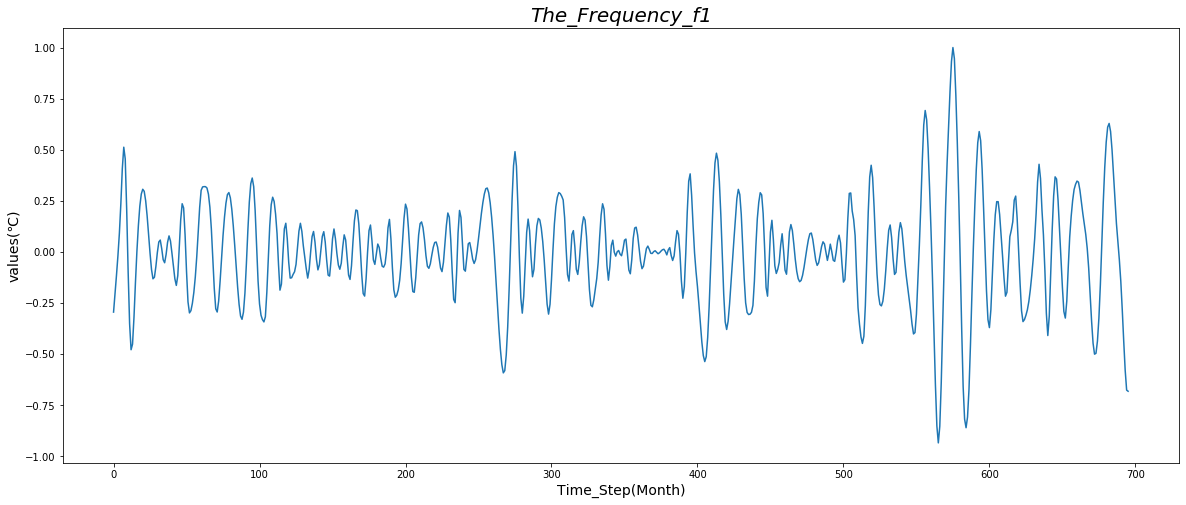

[[[-2.9454e-01]
  [-2.0626e-01]
  [-1.1494e-01]
  [-1.8285e-02]
  [ 9.2434e-02]
  [ 2.3634e-01]
  [ 4.0751e-01]
  [ 5.1294e-01]
  [ 4.5540e-01]
  [ 2.0652e-01]
  [-9.7637e-02]
  [-3.5199e-01]]

 [[-4.7885e-01]
  [-4.5150e-01]
  [-3.1958e-01]
  [-1.4965e-01]
  [ 2.9850e-03]
  [ 1.2816e-01]
  [ 2.2447e-01]
  [ 2.8356e-01]
  [ 3.0691e-01]
  [ 2.9692e-01]
  [ 2.5080e-01]
  [ 1.7690e-01]]

 [[ 8.6898e-02]
  [-6.4059e-03]
  [-8.5830e-02]
  [-1.3152e-01]
  [-1.2382e-01]
  [-7.1080e-02]
  [-3.0445e-03]
  [ 4.8778e-02]
  [ 5.8154e-02]
  [ 1.5810e-02]
  [-3.7963e-02]
  [-5.2927e-02]]

 [[-1.2426e-02]
  [ 4.7069e-02]
  [ 7.8590e-02]
  [ 5.3272e-02]
  [-5.8918e-03]
  [-6.9886e-02]
  [-1.3140e-01]
  [-1.6388e-01]
  [-1.1630e-01]
  [ 1.6081e-02]
  [ 1.5718e-01]
  [ 2.3609e-01]]

 [[ 2.1549e-01]
  [ 8.3197e-02]
  [-9.7596e-02]
  [-2.4477e-01]
  [-2.9853e-01]
  [-2.8754e-01]
  [-2.5153e-01]
  [-1.9811e-01]
  [-1.2294e-01]
  [-2.2837e-02]
  [ 9.6141e-02]
  [ 2.1869e-01]]

 [[ 3.0174e-01]
  [ 3.1849e-01

Epoch 1/200
 - 15s - loss: 0.0579
Epoch 2/200
 - 3s - loss: 0.0553
Epoch 3/200
 - 3s - loss: 0.0500
Epoch 4/200
 - 3s - loss: 0.0427
Epoch 5/200
 - 3s - loss: 0.0421
Epoch 6/200
 - 3s - loss: 0.0386
Epoch 7/200
 - 3s - loss: 0.0359
Epoch 8/200
 - 3s - loss: 0.0355
Epoch 9/200
 - 3s - loss: 0.0319
Epoch 10/200
 - 3s - loss: 0.0312
Epoch 11/200
 - 3s - loss: 0.0296
Epoch 12/200
 - 3s - loss: 0.0288
Epoch 13/200
 - 3s - loss: 0.0281
Epoch 14/200
 - 3s - loss: 0.0268
Epoch 15/200
 - 3s - loss: 0.0280
Epoch 16/200
 - 3s - loss: 0.0281
Epoch 17/200
 - 3s - loss: 0.0263
Epoch 18/200
 - 3s - loss: 0.0310
Epoch 19/200
 - 3s - loss: 0.0252
Epoch 20/200
 - 3s - loss: 0.0257
Epoch 21/200
 - 3s - loss: 0.0240
Epoch 22/200
 - 3s - loss: 0.0245
Epoch 23/200
 - 3s - loss: 0.0234
Epoch 24/200
 - 3s - loss: 0.0236
Epoch 25/200
 - 3s - loss: 0.0224
Epoch 26/200
 - 3s - loss: 0.0211
Epoch 27/200
 - 3s - loss: 0.0206
Epoch 28/200
 - 3s - loss: 0.0206
Epoch 29/200
 - 3s - loss: 0.0204
Epoch 30/200
 - 3s - l

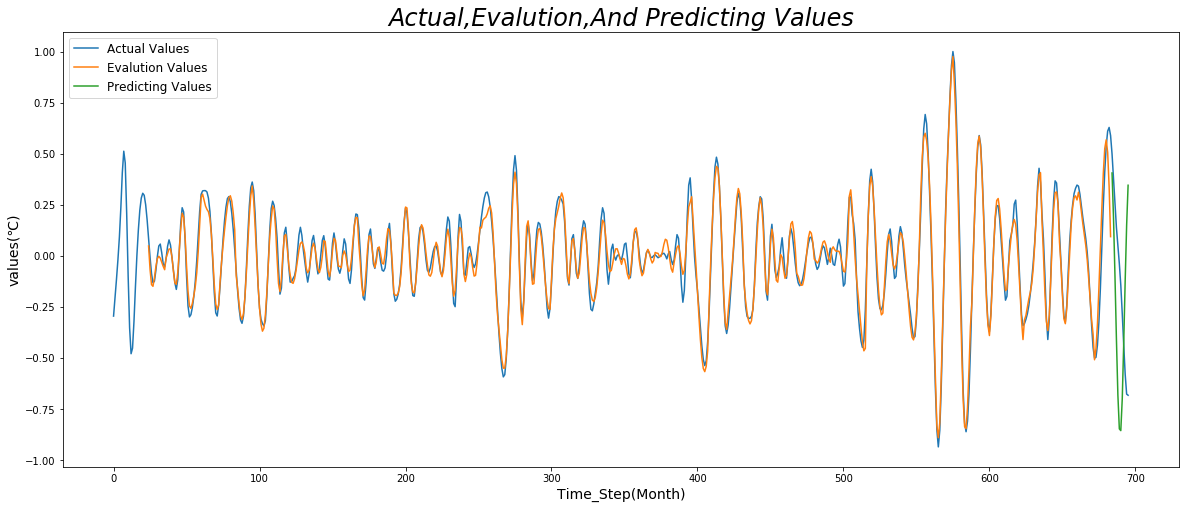

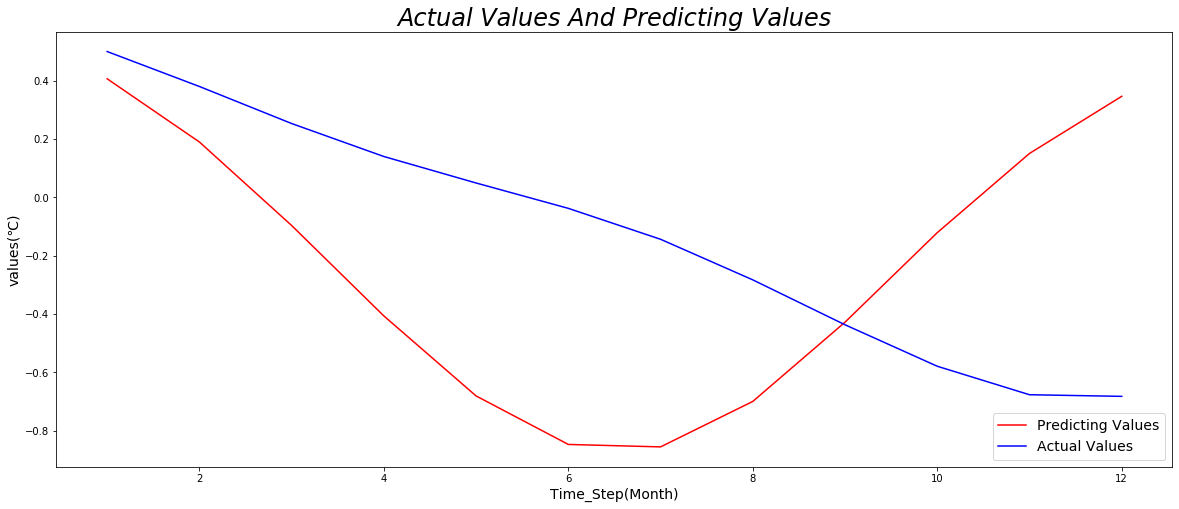

0     -0.438890
1     -0.456720
2     -0.466010
3     -0.466450
4     -0.457420
5     -0.438230
6     -0.408210
7     -0.366670
8     -0.313070
9     -0.247670
10    -0.171950
11    -0.087650
12     0.003699
13     0.100570
14     0.198250
15     0.291170
16     0.373790
17     0.440530
18     0.485840
19     0.504150
20     0.489910
21     0.439690
22     0.358500
23     0.253460
24     0.131690
25     0.000284
26    -0.133640
27    -0.262960
28    -0.380460
29    -0.478240
         ...   
666   -0.207750
667   -0.224480
668   -0.231430
669   -0.227340
670   -0.211140
671   -0.181890
672   -0.138680
673   -0.081387
674   -0.013169
675    0.062013
676    0.140200
677    0.217430
678    0.289740
679    0.353160
680    0.403750
681    0.437530
682    0.450570
683    0.440010
684    0.407250
685    0.355090
686    0.286450
687    0.204210
688    0.111270
689    0.010530
690   -0.095109
691   -0.202750
692   -0.309500
693   -0.412450
694   -0.508710
695   -0.595380
Name: f2, Length: 696, d

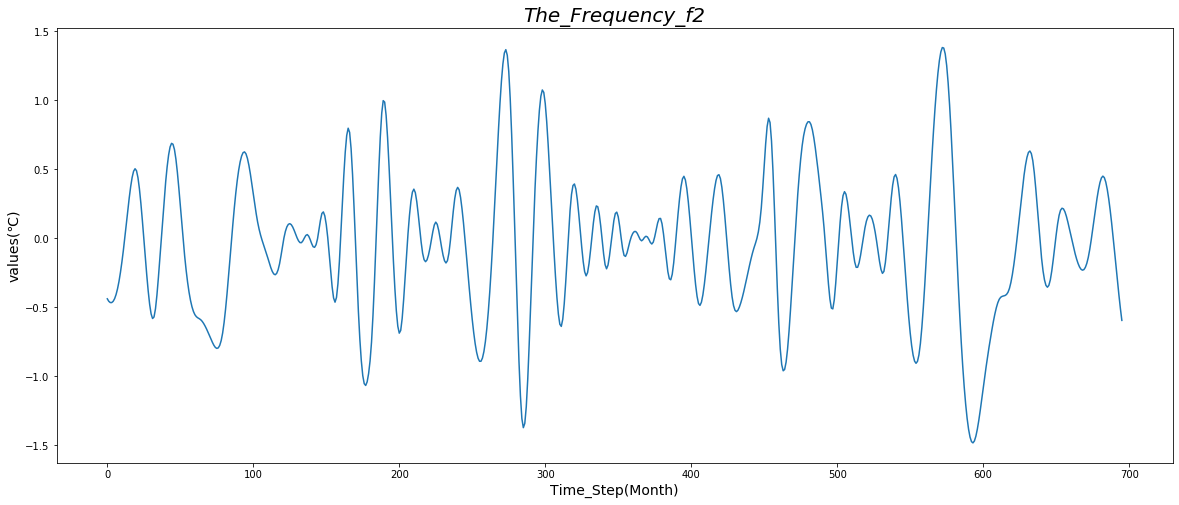

[[[-4.3889e-01]
  [-4.5672e-01]
  [-4.6601e-01]
  [-4.6645e-01]
  [-4.5742e-01]
  [-4.3823e-01]
  [-4.0821e-01]
  [-3.6667e-01]
  [-3.1307e-01]
  [-2.4767e-01]
  [-1.7195e-01]
  [-8.7650e-02]]

 [[ 3.6991e-03]
  [ 1.0057e-01]
  [ 1.9825e-01]
  [ 2.9117e-01]
  [ 3.7379e-01]
  [ 4.4053e-01]
  [ 4.8584e-01]
  [ 5.0415e-01]
  [ 4.8991e-01]
  [ 4.3969e-01]
  [ 3.5850e-01]
  [ 2.5346e-01]]

 [[ 1.3169e-01]
  [ 2.8436e-04]
  [-1.3364e-01]
  [-2.6296e-01]
  [-3.8046e-01]
  [-4.7824e-01]
  [-5.4803e-01]
  [-5.8184e-01]
  [-5.7069e-01]
  [-5.1160e-01]
  [-4.1193e-01]
  [-2.8498e-01]]

 [[-1.4410e-01]
  [ 2.5337e-03]
  [ 1.4806e-01]
  [ 2.8598e-01]
  [ 4.1120e-01]
  [ 5.1893e-01]
  [ 6.0420e-01]
  [ 6.6199e-01]
  [ 6.8813e-01]
  [ 6.8186e-01]
  [ 6.4337e-01]
  [ 5.7378e-01]]

 [[ 4.7821e-01]
  [ 3.6393e-01]
  [ 2.3850e-01]
  [ 1.0950e-01]
  [-1.5500e-02]
  [-1.2986e-01]
  [-2.3097e-01]
  [-3.1827e-01]
  [-3.9149e-01]
  [-4.5060e-01]
  [-4.9659e-01]
  [-5.3066e-01]]

 [[-5.5404e-01]
  [-5.6837e-01

Epoch 1/200
 - 16s - loss: 0.2622
Epoch 2/200
 - 3s - loss: 0.2432
Epoch 3/200
 - 3s - loss: 0.2504
Epoch 4/200
 - 3s - loss: 0.2248
Epoch 5/200
 - 3s - loss: 0.1892
Epoch 6/200
 - 3s - loss: 0.1417
Epoch 7/200
 - 3s - loss: 0.1224
Epoch 8/200
 - 3s - loss: 0.1037
Epoch 9/200
 - 3s - loss: 0.0922
Epoch 10/200
 - 3s - loss: 0.0843
Epoch 11/200
 - 3s - loss: 0.0823
Epoch 12/200
 - 3s - loss: 0.0740
Epoch 13/200
 - 3s - loss: 0.0732
Epoch 14/200
 - 3s - loss: 0.0779
Epoch 15/200
 - 4s - loss: 0.0741
Epoch 16/200
 - 3s - loss: 0.0750
Epoch 17/200
 - 3s - loss: 0.0669
Epoch 18/200
 - 3s - loss: 0.0641
Epoch 19/200
 - 3s - loss: 0.0573
Epoch 20/200
 - 3s - loss: 0.0582
Epoch 21/200
 - 4s - loss: 0.0555
Epoch 22/200
 - 3s - loss: 0.0573
Epoch 23/200
 - 3s - loss: 0.0580
Epoch 24/200
 - 3s - loss: 0.0572
Epoch 25/200
 - 3s - loss: 0.0515
Epoch 26/200
 - 3s - loss: 0.0519
Epoch 27/200
 - 3s - loss: 0.0469
Epoch 28/200
 - 3s - loss: 0.0467
Epoch 29/200
 - 3s - loss: 0.0490
Epoch 30/200
 - 3s - l

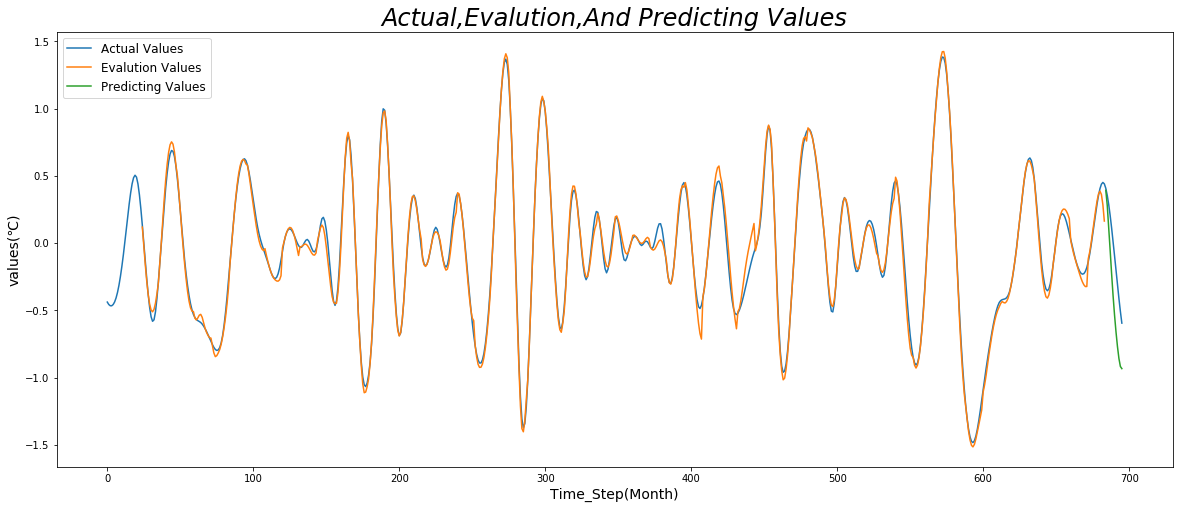

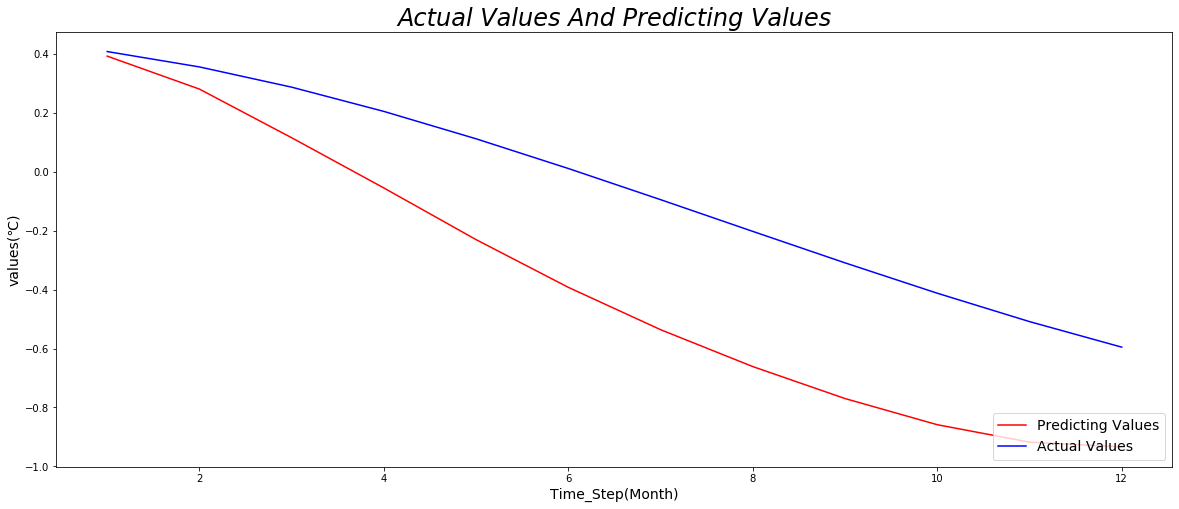

0     -0.538450
1     -0.526230
2     -0.507350
3     -0.481980
4     -0.450610
5     -0.413780
6     -0.372030
7     -0.325890
8     -0.275900
9     -0.222610
10    -0.166550
11    -0.108270
12    -0.048294
13     0.012829
14     0.074562
15     0.136370
16     0.197700
17     0.258030
18     0.316810
19     0.373510
20     0.427580
21     0.478490
22     0.525830
23     0.569200
24     0.608230
25     0.642540
26     0.671750
27     0.695490
28     0.713370
29     0.725020
         ...   
666    0.099044
667    0.078852
668    0.057244
669    0.034219
670    0.009991
671   -0.015117
672   -0.040758
673   -0.066578
674   -0.092221
675   -0.117330
676   -0.141550
677   -0.164520
678   -0.185880
679   -0.205280
680   -0.222370
681   -0.236780
682   -0.248170
683   -0.256340
684   -0.261390
685   -0.263480
686   -0.262780
687   -0.259440
688   -0.253620
689   -0.245470
690   -0.235150
691   -0.222820
692   -0.208650
693   -0.192820
694   -0.175480
695   -0.156810
Name: f3, Length: 696, d

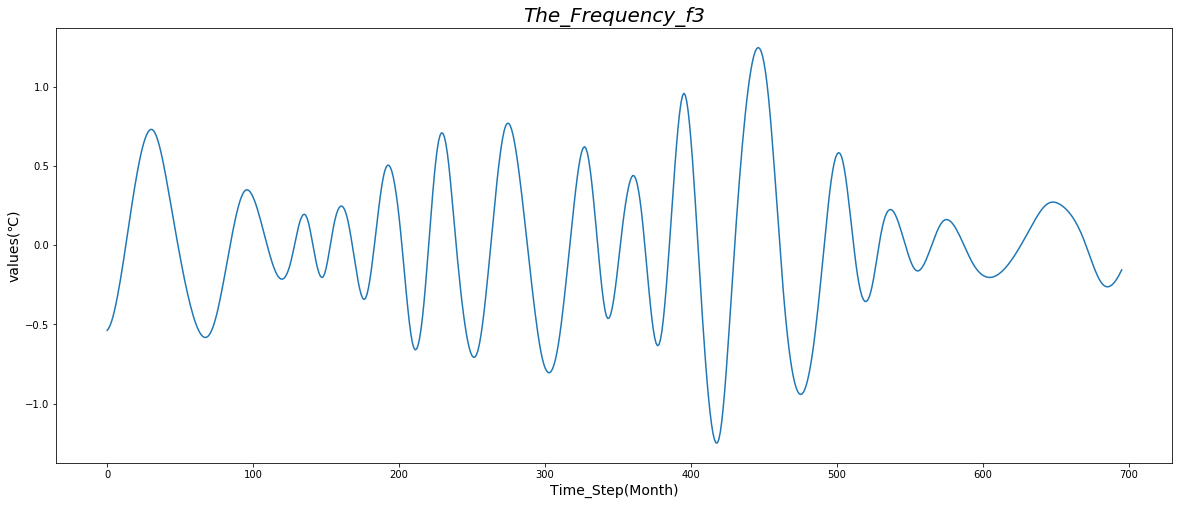

[[[-5.3845e-01]
  [-5.2623e-01]
  [-5.0735e-01]
  [-4.8198e-01]
  [-4.5061e-01]
  [-4.1378e-01]
  [-3.7203e-01]
  [-3.2589e-01]
  [-2.7590e-01]
  [-2.2261e-01]
  [-1.6655e-01]
  [-1.0827e-01]]

 [[-4.8294e-02]
  [ 1.2829e-02]
  [ 7.4562e-02]
  [ 1.3637e-01]
  [ 1.9770e-01]
  [ 2.5803e-01]
  [ 3.1681e-01]
  [ 3.7351e-01]
  [ 4.2758e-01]
  [ 4.7849e-01]
  [ 5.2583e-01]
  [ 5.6920e-01]]

 [[ 6.0823e-01]
  [ 6.4254e-01]
  [ 6.7175e-01]
  [ 6.9549e-01]
  [ 7.1337e-01]
  [ 7.2502e-01]
  [ 7.3005e-01]
  [ 7.2810e-01]
  [ 7.1888e-01]
  [ 7.0263e-01]
  [ 6.7994e-01]
  [ 6.5140e-01]]

 [[ 6.1765e-01]
  [ 5.7930e-01]
  [ 5.3698e-01]
  [ 4.9129e-01]
  [ 4.4287e-01]
  [ 3.9232e-01]
  [ 3.4028e-01]
  [ 2.8736e-01]
  [ 2.3413e-01]
  [ 1.8096e-01]
  [ 1.2808e-01]
  [ 7.5673e-02]]

 [[ 2.3922e-02]
  [-2.6981e-02]
  [-7.6848e-02]
  [-1.2549e-01]
  [-1.7272e-01]
  [-2.1835e-01]
  [-2.6219e-01]
  [-3.0405e-01]
  [-3.4374e-01]
  [-3.8107e-01]
  [-4.1587e-01]
  [-4.4793e-01]]

 [[-4.7707e-01]
  [-5.0310e-01

Epoch 1/200
 - 17s - loss: 0.1739
Epoch 2/200
 - 3s - loss: 0.1359
Epoch 3/200
 - 3s - loss: 0.0894
Epoch 4/200
 - 3s - loss: 0.0711
Epoch 5/200
 - 3s - loss: 0.0503
Epoch 6/200
 - 3s - loss: 0.0399
Epoch 7/200
 - 3s - loss: 0.0357
Epoch 8/200
 - 3s - loss: 0.0295
Epoch 9/200
 - 3s - loss: 0.0195
Epoch 10/200
 - 3s - loss: 0.0153
Epoch 11/200
 - 3s - loss: 0.0191
Epoch 12/200
 - 3s - loss: 0.0171
Epoch 13/200
 - 3s - loss: 0.0179
Epoch 14/200
 - 3s - loss: 0.0155
Epoch 15/200
 - 3s - loss: 0.0158
Epoch 16/200
 - 3s - loss: 0.0129
Epoch 17/200
 - 3s - loss: 0.0115
Epoch 18/200
 - 3s - loss: 0.0105
Epoch 19/200
 - 3s - loss: 0.0106
Epoch 20/200
 - 4s - loss: 0.0111
Epoch 21/200
 - 3s - loss: 0.0120
Epoch 22/200
 - 3s - loss: 0.0119
Epoch 23/200
 - 3s - loss: 0.0130
Epoch 24/200
 - 3s - loss: 0.0107
Epoch 25/200
 - 3s - loss: 0.0087
Epoch 26/200
 - 3s - loss: 0.0086
Epoch 27/200
 - 3s - loss: 0.0079
Epoch 28/200
 - 3s - loss: 0.0081
Epoch 29/200
 - 3s - loss: 0.0097
Epoch 30/200
 - 3s - l

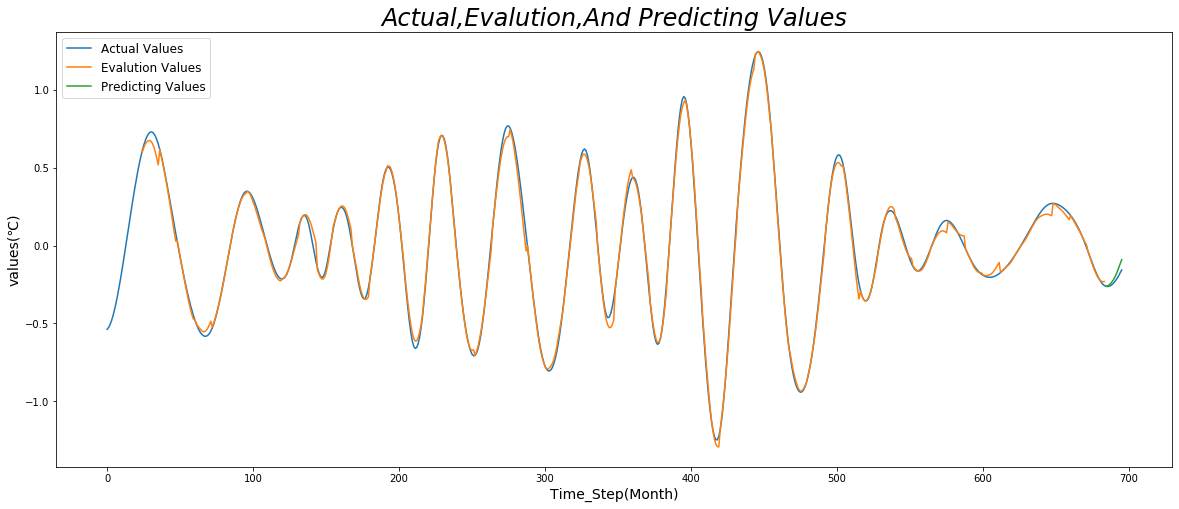

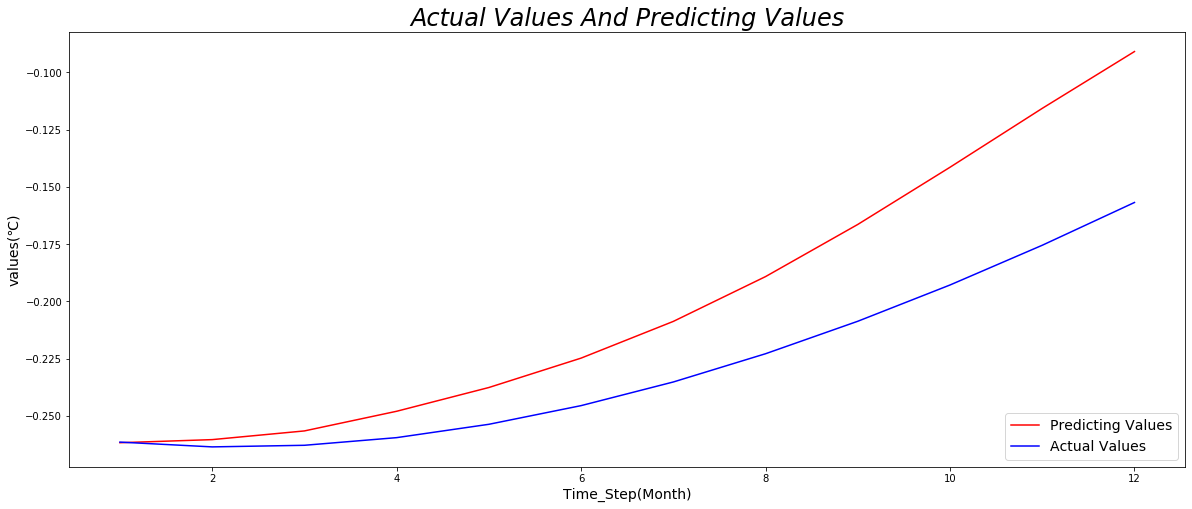

0     -0.215810
1     -0.214380
2     -0.212910
3     -0.211390
4     -0.209820
5     -0.208200
6     -0.206530
7     -0.204810
8     -0.203030
9     -0.201200
10    -0.199310
11    -0.197360
12    -0.195360
13    -0.193290
14    -0.191160
15    -0.188960
16    -0.186700
17    -0.184380
18    -0.181980
19    -0.179520
20    -0.176990
21    -0.174390
22    -0.171710
23    -0.168960
24    -0.166130
25    -0.163230
26    -0.160250
27    -0.157190
28    -0.154050
29    -0.150820
         ...   
666    0.292430
667    0.287580
668    0.282480
669    0.277130
670    0.271540
671    0.265710
672    0.259650
673    0.253350
674    0.246820
675    0.240070
676    0.233090
677    0.225900
678    0.218490
679    0.210860
680    0.203030
681    0.194980
682    0.186740
683    0.178290
684    0.169650
685    0.160820
686    0.151790
687    0.142550
688    0.133110
689    0.123430
690    0.113530
691    0.103400
692    0.093041
693    0.082458
694    0.071655
695    0.060635
Name: f4, Length: 696, d

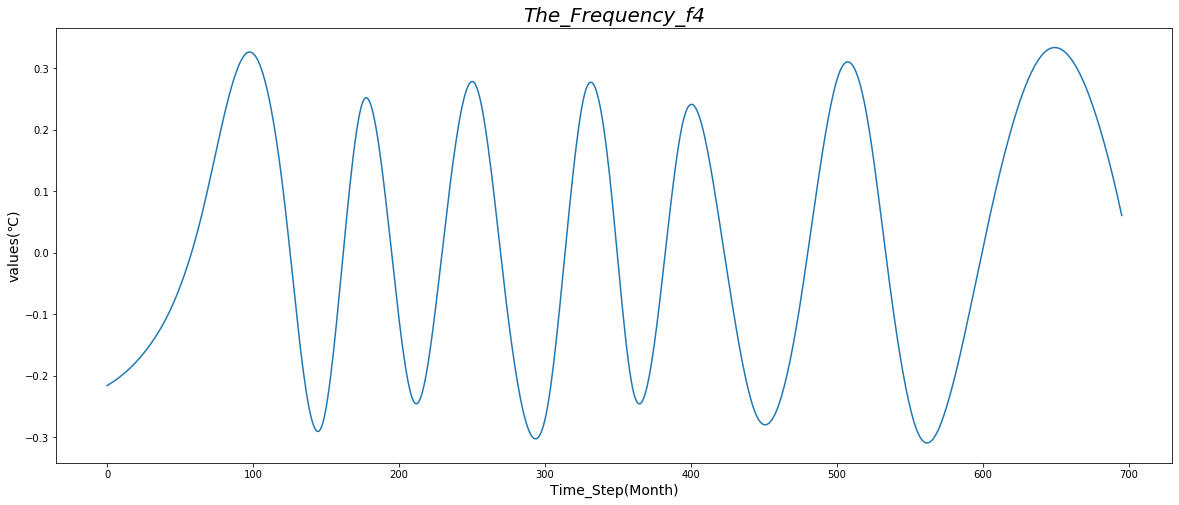

[[[-0.21581  ]
  [-0.21438  ]
  [-0.21291  ]
  [-0.21139  ]
  [-0.20982  ]
  [-0.2082   ]
  [-0.20653  ]
  [-0.20481  ]
  [-0.20303  ]
  [-0.2012   ]
  [-0.19931  ]
  [-0.19736  ]]

 [[-0.19536  ]
  [-0.19329  ]
  [-0.19116  ]
  [-0.18896  ]
  [-0.1867   ]
  [-0.18438  ]
  [-0.18198  ]
  [-0.17952  ]
  [-0.17699  ]
  [-0.17439  ]
  [-0.17171  ]
  [-0.16896  ]]

 [[-0.16613  ]
  [-0.16323  ]
  [-0.16025  ]
  [-0.15719  ]
  [-0.15405  ]
  [-0.15082  ]
  [-0.14752  ]
  [-0.14412  ]
  [-0.14063  ]
  [-0.13703  ]
  [-0.13331  ]
  [-0.12948  ]]

 [[-0.12553  ]
  [-0.12146  ]
  [-0.11725  ]
  [-0.11291  ]
  [-0.10842  ]
  [-0.10379  ]
  [-0.099013 ]
  [-0.094078 ]
  [-0.088983 ]
  [-0.083723 ]
  [-0.078293 ]
  [-0.072689 ]]

 [[-0.066905 ]
  [-0.060937 ]
  [-0.054779 ]
  [-0.048428 ]
  [-0.041877 ]
  [-0.035123 ]
  [-0.028161 ]
  [-0.020985 ]
  [-0.01359  ]
  [-0.0059729]
  [ 0.0018726]
  [ 0.0099509]]

 [[ 0.018267 ]
  [ 0.026826 ]
  [ 0.035632 ]
  [ 0.04469  ]
  [ 0.054005 ]
  [ 0.06358  ]


Epoch 1/200
 - 18s - loss: 0.0325
Epoch 2/200
 - 3s - loss: 0.0121
Epoch 3/200
 - 3s - loss: 0.0071
Epoch 4/200
 - 3s - loss: 0.0040
Epoch 5/200
 - 3s - loss: 0.0032
Epoch 6/200
 - 3s - loss: 0.0021
Epoch 7/200
 - 3s - loss: 0.0020
Epoch 8/200
 - 3s - loss: 0.0015
Epoch 9/200
 - 3s - loss: 0.0011
Epoch 10/200
 - 3s - loss: 7.7658e-04
Epoch 11/200
 - 4s - loss: 0.0012
Epoch 12/200
 - 3s - loss: 8.7805e-04
Epoch 13/200
 - 3s - loss: 7.8097e-04
Epoch 14/200
 - 3s - loss: 6.9020e-04
Epoch 15/200
 - 3s - loss: 6.5020e-04
Epoch 16/200
 - 3s - loss: 8.0807e-04
Epoch 17/200
 - 4s - loss: 5.9744e-04
Epoch 18/200
 - 3s - loss: 8.8997e-04
Epoch 19/200
 - 3s - loss: 6.6377e-04
Epoch 20/200
 - 3s - loss: 7.7341e-04
Epoch 21/200
 - 3s - loss: 6.2981e-04
Epoch 22/200
 - 3s - loss: 5.2700e-04
Epoch 23/200
 - 3s - loss: 6.4005e-04
Epoch 24/200
 - 3s - loss: 5.0907e-04
Epoch 25/200
 - 3s - loss: 0.0011
Epoch 26/200
 - 3s - loss: 6.7587e-04
Epoch 27/200
 - 3s - loss: 5.4999e-04
Epoch 28/200
 - 3s - loss:

(55, 12)


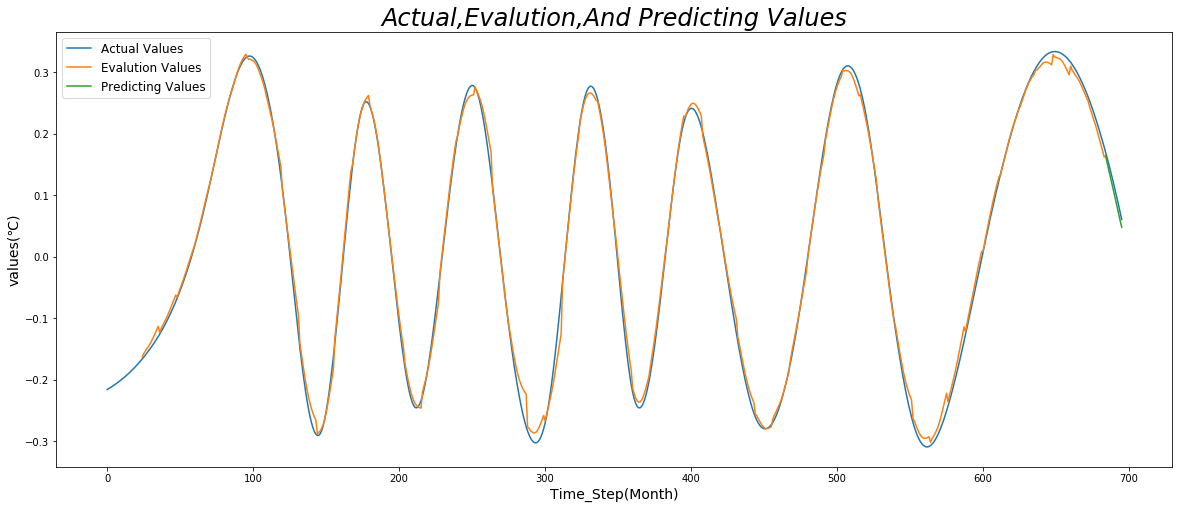

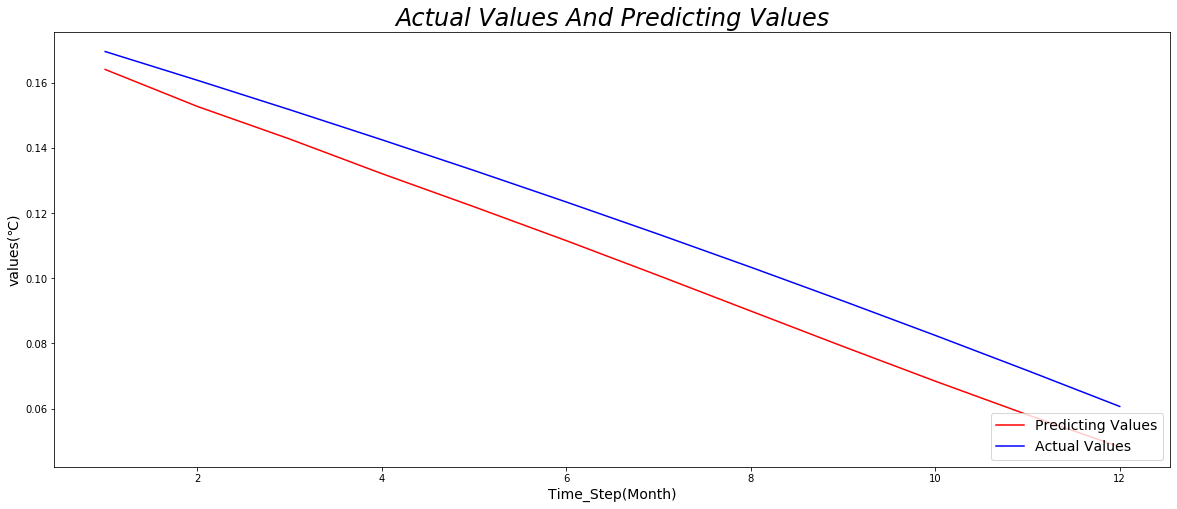

0      0.004482
1      0.003265
2      0.002159
3      0.001161
4      0.000266
5     -0.000529
6     -0.001226
7     -0.001830
8     -0.002343
9     -0.002768
10    -0.003109
11    -0.003368
12    -0.003548
13    -0.003654
14    -0.003686
15    -0.003650
16    -0.003548
17    -0.003384
18    -0.003162
19    -0.002884
20    -0.002554
21    -0.002177
22    -0.001754
23    -0.001289
24    -0.000785
25    -0.000244
26     0.000330
27     0.000934
28     0.001566
29     0.002224
         ...   
666   -0.162200
667   -0.162980
668   -0.163680
669   -0.164280
670   -0.164790
671   -0.165210
672   -0.165550
673   -0.165800
674   -0.165960
675   -0.166040
676   -0.166040
677   -0.165950
678   -0.165780
679   -0.165530
680   -0.165200
681   -0.164790
682   -0.164300
683   -0.163730
684   -0.163080
685   -0.162360
686   -0.161560
687   -0.160680
688   -0.159730
689   -0.158710
690   -0.157610
691   -0.156440
692   -0.155200
693   -0.153890
694   -0.152510
695   -0.151060
Name: f5, Length: 696, d

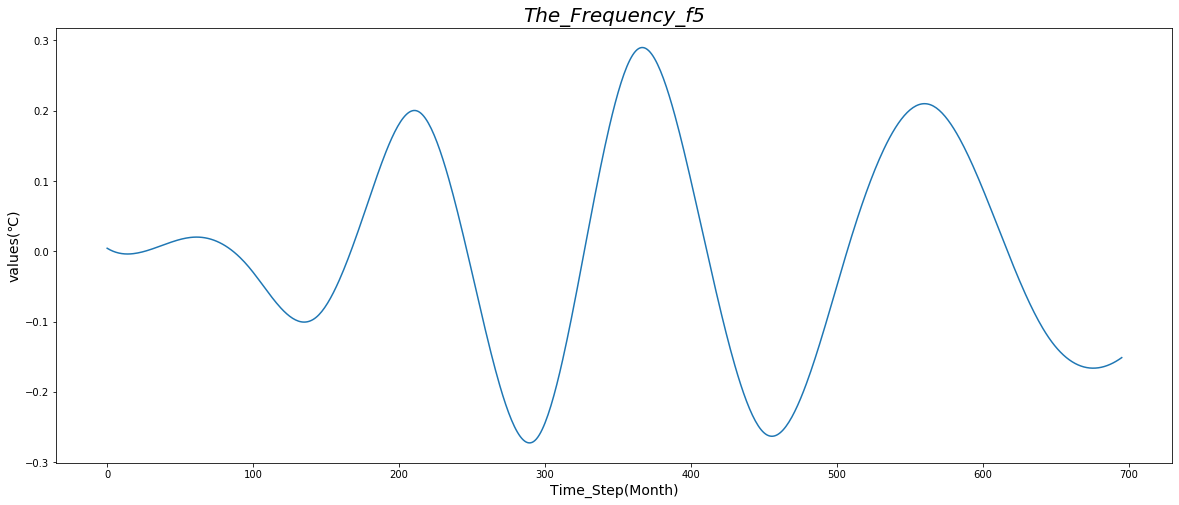

[[[ 4.4815e-03]
  [ 3.2649e-03]
  [ 2.1594e-03]
  [ 1.1610e-03]
  [ 2.6607e-04]
  [-5.2874e-04]
  [-1.2265e-03]
  [-1.8303e-03]
  [-2.3432e-03]
  [-2.7684e-03]
  [-3.1089e-03]
  [-3.3678e-03]]

 [[-3.5483e-03]
  [-3.6535e-03]
  [-3.6864e-03]
  [-3.6501e-03]
  [-3.5482e-03]
  [-3.3842e-03]
  [-3.1616e-03]
  [-2.8838e-03]
  [-2.5544e-03]
  [-2.1766e-03]
  [-1.7537e-03]
  [-1.2888e-03]]

 [[-7.8468e-04]
  [-2.4422e-04]
  [ 3.2968e-04]
  [ 9.3417e-04]
  [ 1.5665e-03]
  [ 2.2240e-03]
  [ 2.9039e-03]
  [ 3.6035e-03]
  [ 4.3202e-03]
  [ 5.0511e-03]
  [ 5.7937e-03]
  [ 6.5452e-03]]

 [[ 7.3028e-03]
  [ 8.0640e-03]
  [ 8.8259e-03]
  [ 9.5859e-03]
  [ 1.0341e-02]
  [ 1.1089e-02]
  [ 1.1827e-02]
  [ 1.2552e-02]
  [ 1.3262e-02]
  [ 1.3954e-02]
  [ 1.4624e-02]
  [ 1.5271e-02]]

 [[ 1.5892e-02]
  [ 1.6484e-02]
  [ 1.7044e-02]
  [ 1.7570e-02]
  [ 1.8058e-02]
  [ 1.8507e-02]
  [ 1.8913e-02]
  [ 1.9274e-02]
  [ 1.9587e-02]
  [ 1.9850e-02]
  [ 2.0061e-02]
  [ 2.0217e-02]]

 [[ 2.0317e-02]
  [ 2.0360e-02

Epoch 1/200
 - 19s - loss: 0.0150
Epoch 2/200
 - 4s - loss: 0.0060
Epoch 3/200
 - 4s - loss: 0.0017
Epoch 4/200
 - 4s - loss: 8.3842e-04
Epoch 5/200
 - 4s - loss: 3.4447e-04
Epoch 6/200
 - 3s - loss: 2.0426e-04
Epoch 7/200
 - 3s - loss: 1.2738e-04
Epoch 8/200
 - 3s - loss: 1.4439e-04
Epoch 9/200
 - 3s - loss: 1.2698e-04
Epoch 10/200
 - 3s - loss: 1.0254e-04
Epoch 11/200
 - 3s - loss: 8.3503e-05
Epoch 12/200
 - 3s - loss: 8.9329e-05
Epoch 13/200
 - 3s - loss: 9.4785e-05
Epoch 14/200
 - 3s - loss: 8.3544e-05
Epoch 15/200
 - 3s - loss: 7.6476e-05
Epoch 16/200
 - 3s - loss: 1.1036e-04
Epoch 17/200
 - 3s - loss: 8.6912e-05
Epoch 18/200
 - 3s - loss: 8.3942e-05
Epoch 19/200
 - 3s - loss: 6.7724e-05
Epoch 20/200
 - 3s - loss: 5.8210e-05
Epoch 21/200
 - 3s - loss: 6.3225e-05
Epoch 22/200
 - 3s - loss: 1.1903e-04
Epoch 23/200
 - 3s - loss: 8.6891e-05
Epoch 24/200
 - 3s - loss: 1.0856e-04
Epoch 25/200
 - 3s - loss: 9.4537e-05
Epoch 26/200
 - 4s - loss: 4.8653e-05
Epoch 27/200
 - 3s - loss: 5.417

(55, 12)


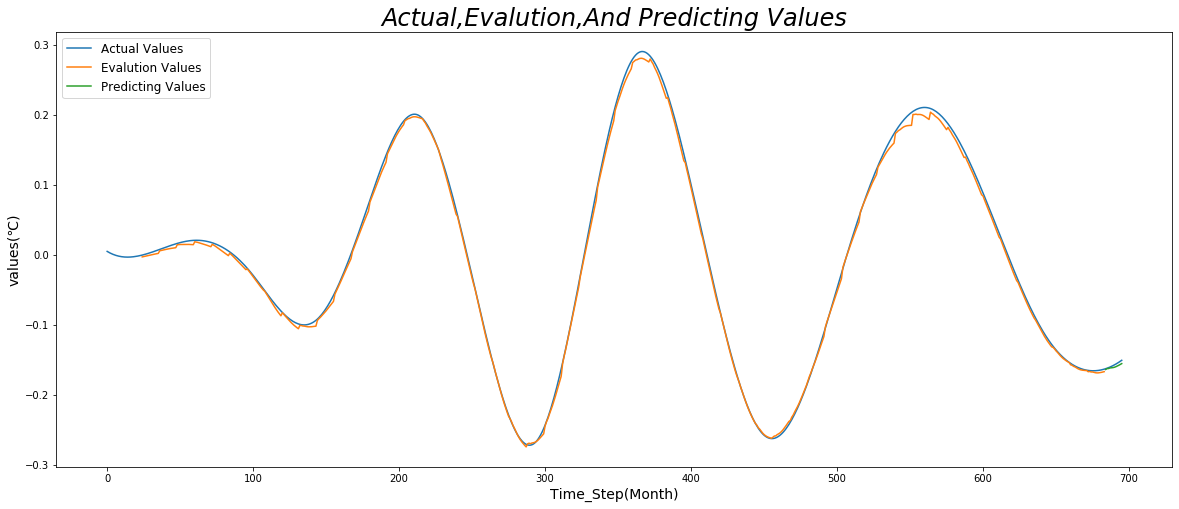

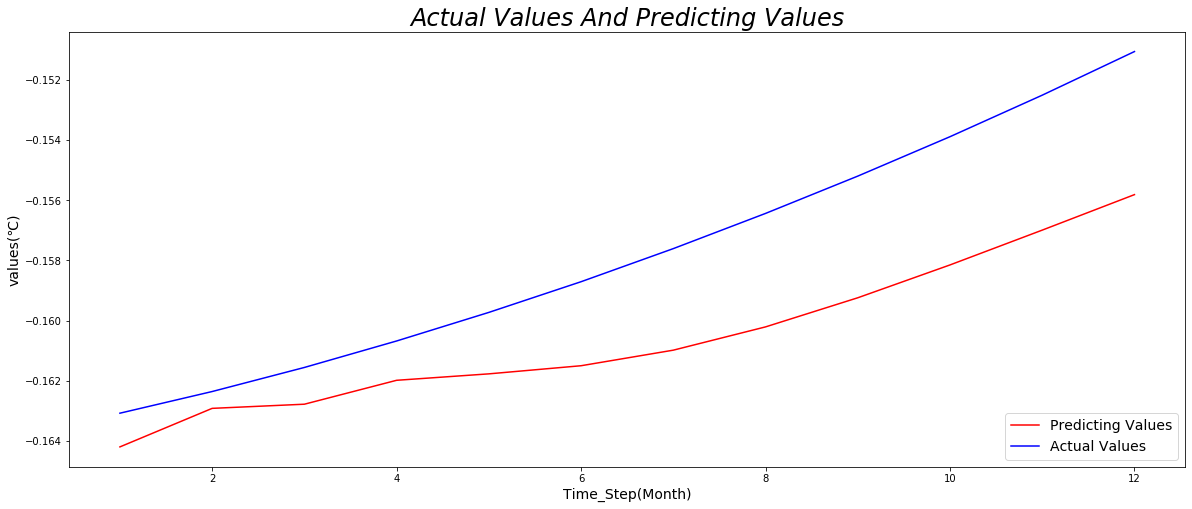

0     -0.12887
1     -0.12956
2     -0.13022
3     -0.13084
4     -0.13142
5     -0.13198
6     -0.13249
7     -0.13297
8     -0.13342
9     -0.13382
10    -0.13418
11    -0.13451
12    -0.13479
13    -0.13504
14    -0.13524
15    -0.13539
16    -0.13551
17    -0.13557
18    -0.13559
19    -0.13557
20    -0.13549
21    -0.13536
22    -0.13519
23    -0.13496
24    -0.13468
25    -0.13434
26    -0.13395
27    -0.13351
28    -0.13302
29    -0.13247
        ...   
666   -0.21799
667   -0.21834
668   -0.21865
669   -0.21894
670   -0.21918
671   -0.21940
672   -0.21958
673   -0.21972
674   -0.21984
675   -0.21992
676   -0.21996
677   -0.21998
678   -0.21996
679   -0.21991
680   -0.21983
681   -0.21972
682   -0.21958
683   -0.21940
684   -0.21920
685   -0.21897
686   -0.21871
687   -0.21842
688   -0.21810
689   -0.21775
690   -0.21738
691   -0.21698
692   -0.21655
693   -0.21609
694   -0.21561
695   -0.21510
Name: f6, Length: 696, dtype: float64
(696,)


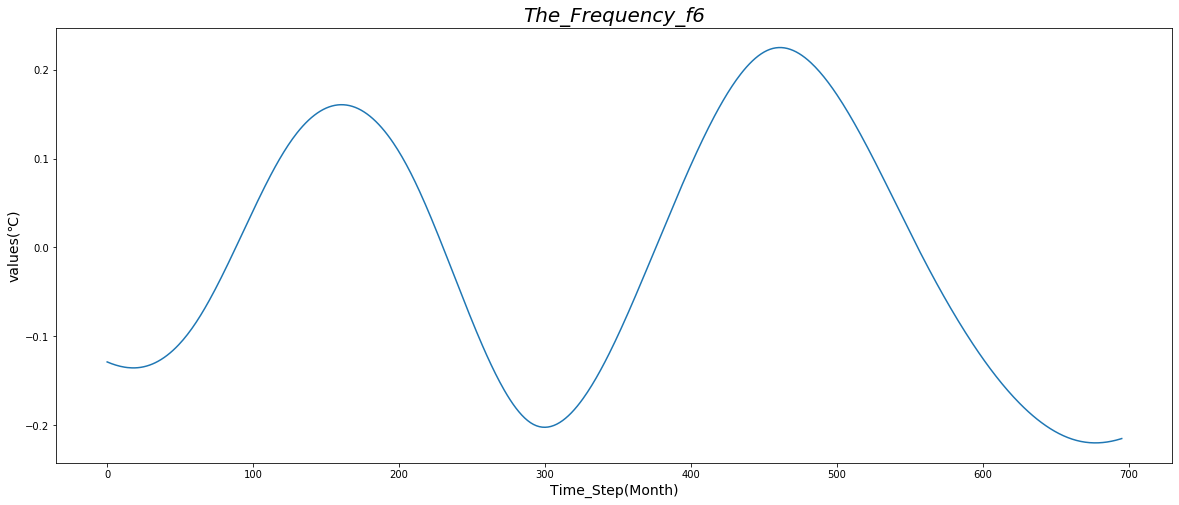

[[[-0.12887   ]
  [-0.12956   ]
  [-0.13022   ]
  [-0.13084   ]
  [-0.13142   ]
  [-0.13198   ]
  [-0.13249   ]
  [-0.13297   ]
  [-0.13342   ]
  [-0.13382   ]
  [-0.13418   ]
  [-0.13451   ]]

 [[-0.13479   ]
  [-0.13504   ]
  [-0.13524   ]
  [-0.13539   ]
  [-0.13551   ]
  [-0.13557   ]
  [-0.13559   ]
  [-0.13557   ]
  [-0.13549   ]
  [-0.13536   ]
  [-0.13519   ]
  [-0.13496   ]]

 [[-0.13468   ]
  [-0.13434   ]
  [-0.13395   ]
  [-0.13351   ]
  [-0.13302   ]
  [-0.13247   ]
  [-0.13187   ]
  [-0.13121   ]
  [-0.13049   ]
  [-0.12972   ]
  [-0.12889   ]
  [-0.12801   ]]

 [[-0.12707   ]
  [-0.12608   ]
  [-0.12502   ]
  [-0.12391   ]
  [-0.12274   ]
  [-0.12151   ]
  [-0.12022   ]
  [-0.11888   ]
  [-0.11747   ]
  [-0.116     ]
  [-0.11448   ]
  [-0.11289   ]]

 [[-0.11124   ]
  [-0.10953   ]
  [-0.10776   ]
  [-0.10593   ]
  [-0.10404   ]
  [-0.10208   ]
  [-0.10006   ]
  [-0.097974  ]
  [-0.095827  ]
  [-0.093616  ]
  [-0.091342  ]
  [-0.089005  ]]

 [[-0.086605  ]
  [-0.084145  

Epoch 1/200
 - 19s - loss: 0.0099
Epoch 2/200
 - 3s - loss: 0.0037
Epoch 3/200
 - 4s - loss: 0.0022
Epoch 4/200
 - 3s - loss: 9.6116e-04
Epoch 5/200
 - 4s - loss: 3.5371e-04
Epoch 6/200
 - 4s - loss: 1.6495e-04
Epoch 7/200
 - 3s - loss: 8.8039e-05
Epoch 8/200
 - 3s - loss: 3.9561e-05
Epoch 9/200
 - 3s - loss: 4.3731e-05
Epoch 10/200
 - 3s - loss: 2.5440e-05
Epoch 11/200
 - 3s - loss: 1.5822e-05
Epoch 12/200
 - 3s - loss: 1.3299e-05
Epoch 13/200
 - 3s - loss: 2.0321e-05
Epoch 14/200
 - 3s - loss: 1.0425e-05
Epoch 15/200
 - 3s - loss: 1.7108e-05
Epoch 16/200
 - 3s - loss: 2.0139e-05
Epoch 17/200
 - 3s - loss: 1.0128e-05
Epoch 18/200
 - 3s - loss: 1.3927e-05
Epoch 19/200
 - 3s - loss: 1.0642e-05
Epoch 20/200
 - 3s - loss: 1.5915e-05
Epoch 21/200
 - 3s - loss: 1.6763e-05
Epoch 22/200
 - 3s - loss: 1.0431e-05
Epoch 23/200
 - 3s - loss: 1.0062e-05
Epoch 24/200
 - 3s - loss: 1.0418e-05
Epoch 25/200
 - 3s - loss: 2.0805e-05
Epoch 26/200
 - 3s - loss: 1.0572e-05
Epoch 27/200
 - 3s - loss: 1.633

(55, 12)


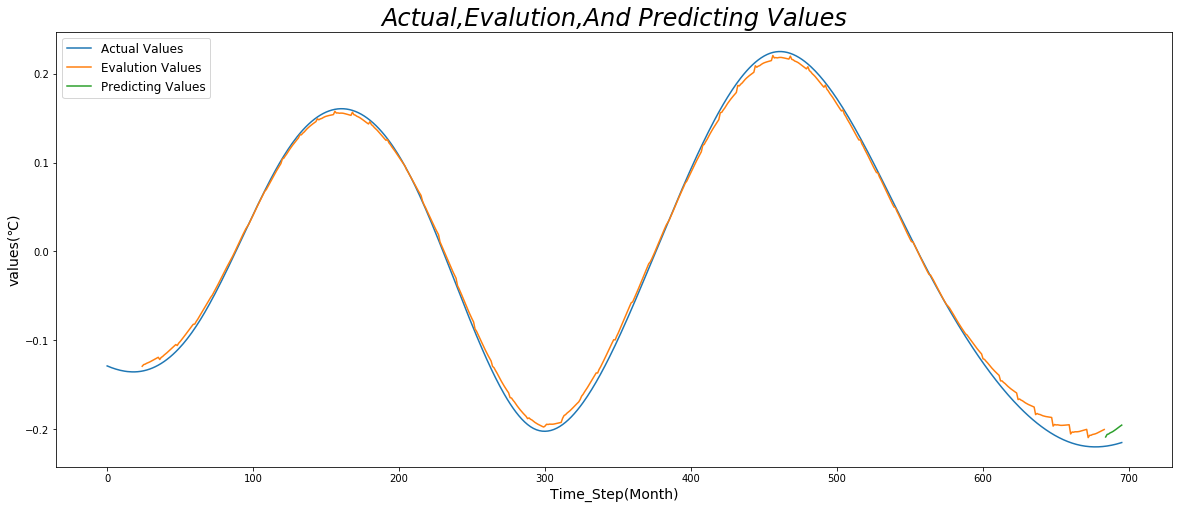

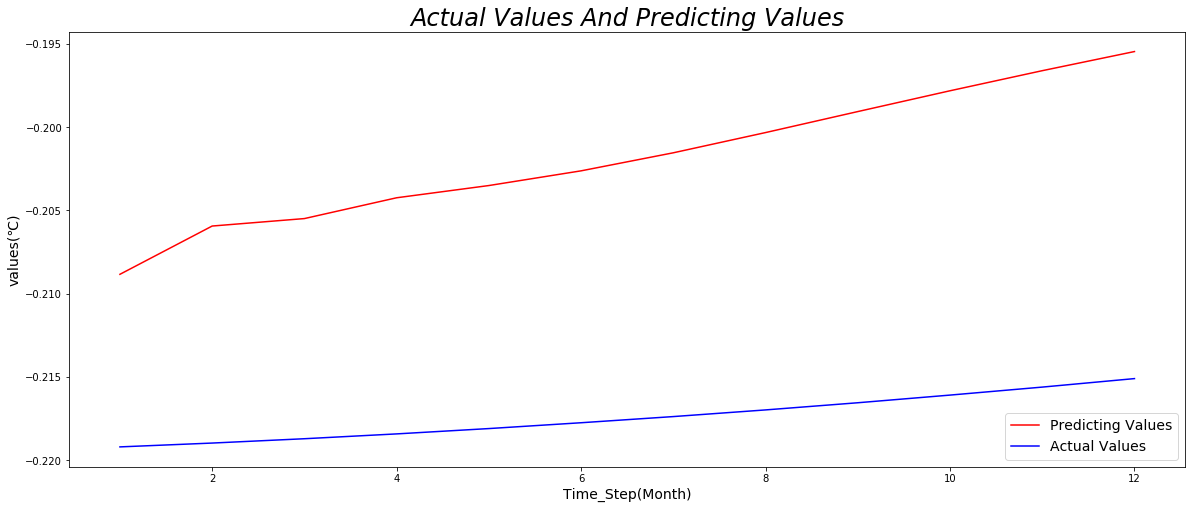

0      0.051841
1      0.051858
2      0.051870
3      0.051877
4      0.051878
5      0.051875
6      0.051866
7      0.051851
8      0.051832
9      0.051807
10     0.051776
11     0.051741
12     0.051700
13     0.051653
14     0.051601
15     0.051543
16     0.051480
17     0.051411
18     0.051337
19     0.051257
20     0.051172
21     0.051081
22     0.050984
23     0.050882
24     0.050774
25     0.050660
26     0.050542
27     0.050418
28     0.050288
29     0.050153
         ...   
666    0.042237
667    0.042350
668    0.042460
669    0.042567
670    0.042670
671    0.042770
672    0.042867
673    0.042961
674    0.043051
675    0.043139
676    0.043223
677    0.043303
678    0.043380
679    0.043454
680    0.043525
681    0.043593
682    0.043657
683    0.043718
684    0.043776
685    0.043830
686    0.043882
687    0.043930
688    0.043975
689    0.044017
690    0.044056
691    0.044092
692    0.044124
693    0.044154
694    0.044180
695    0.044204
Name: f7, Length: 696, d

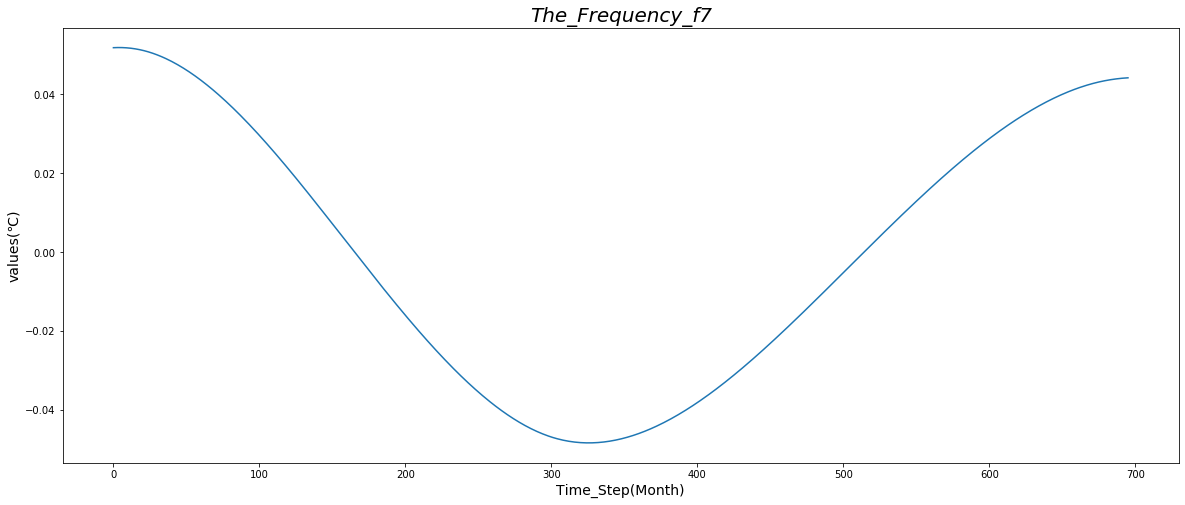

[[[ 5.1841e-02]
  [ 5.1858e-02]
  [ 5.1870e-02]
  [ 5.1877e-02]
  [ 5.1878e-02]
  [ 5.1875e-02]
  [ 5.1866e-02]
  [ 5.1851e-02]
  [ 5.1832e-02]
  [ 5.1807e-02]
  [ 5.1776e-02]
  [ 5.1741e-02]]

 [[ 5.1700e-02]
  [ 5.1653e-02]
  [ 5.1601e-02]
  [ 5.1543e-02]
  [ 5.1480e-02]
  [ 5.1411e-02]
  [ 5.1337e-02]
  [ 5.1257e-02]
  [ 5.1172e-02]
  [ 5.1081e-02]
  [ 5.0984e-02]
  [ 5.0882e-02]]

 [[ 5.0774e-02]
  [ 5.0660e-02]
  [ 5.0542e-02]
  [ 5.0418e-02]
  [ 5.0288e-02]
  [ 5.0153e-02]
  [ 5.0013e-02]
  [ 4.9868e-02]
  [ 4.9718e-02]
  [ 4.9562e-02]
  [ 4.9402e-02]
  [ 4.9236e-02]]

 [[ 4.9065e-02]
  [ 4.8889e-02]
  [ 4.8709e-02]
  [ 4.8523e-02]
  [ 4.8333e-02]
  [ 4.8138e-02]
  [ 4.7938e-02]
  [ 4.7733e-02]
  [ 4.7524e-02]
  [ 4.7310e-02]
  [ 4.7091e-02]
  [ 4.6868e-02]]

 [[ 4.6640e-02]
  [ 4.6408e-02]
  [ 4.6171e-02]
  [ 4.5930e-02]
  [ 4.5685e-02]
  [ 4.5435e-02]
  [ 4.5181e-02]
  [ 4.4923e-02]
  [ 4.4660e-02]
  [ 4.4394e-02]
  [ 4.4123e-02]
  [ 4.3848e-02]]

 [[ 4.3570e-02]
  [ 4.3287e-02

Epoch 1/200
 - 21s - loss: 9.1843e-04
Epoch 2/200
 - 3s - loss: 2.7154e-04
Epoch 3/200
 - 3s - loss: 1.3935e-04
Epoch 4/200
 - 3s - loss: 9.5082e-05
Epoch 5/200
 - 3s - loss: 7.2164e-05
Epoch 6/200
 - 3s - loss: 5.9956e-05
Epoch 7/200
 - 3s - loss: 4.3871e-05
Epoch 8/200
 - 3s - loss: 4.5107e-05
Epoch 9/200
 - 3s - loss: 3.8365e-05
Epoch 10/200
 - 3s - loss: 2.8436e-05
Epoch 11/200
 - 3s - loss: 2.5824e-05
Epoch 12/200
 - 3s - loss: 3.1736e-05
Epoch 13/200
 - 3s - loss: 2.2747e-05
Epoch 14/200
 - 3s - loss: 2.9429e-05
Epoch 15/200
 - 3s - loss: 2.3217e-05
Epoch 16/200
 - 4s - loss: 1.7415e-05
Epoch 17/200
 - 3s - loss: 1.3280e-05
Epoch 18/200
 - 3s - loss: 9.9693e-06
Epoch 19/200
 - 3s - loss: 5.8621e-06
Epoch 20/200
 - 3s - loss: 3.7450e-06
Epoch 21/200
 - 4s - loss: 3.6421e-06
Epoch 22/200
 - 3s - loss: 4.7567e-06
Epoch 23/200
 - 3s - loss: 8.6136e-06
Epoch 24/200
 - 3s - loss: 3.6185e-06
Epoch 25/200
 - 3s - loss: 3.0943e-06
Epoch 26/200
 - 3s - loss: 8.8992e-07
Epoch 27/200
 - 3s -

(55, 12)


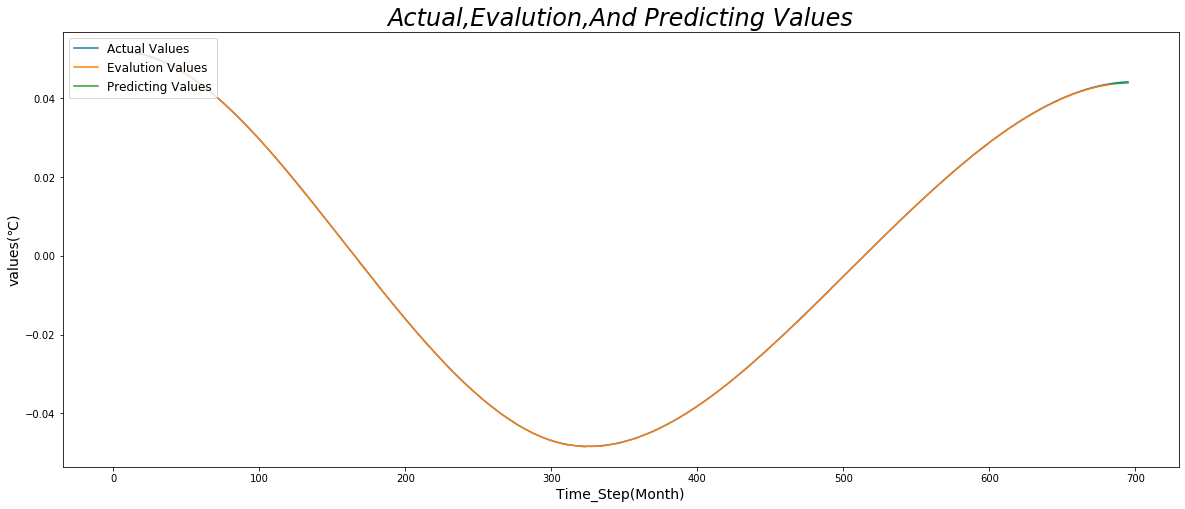

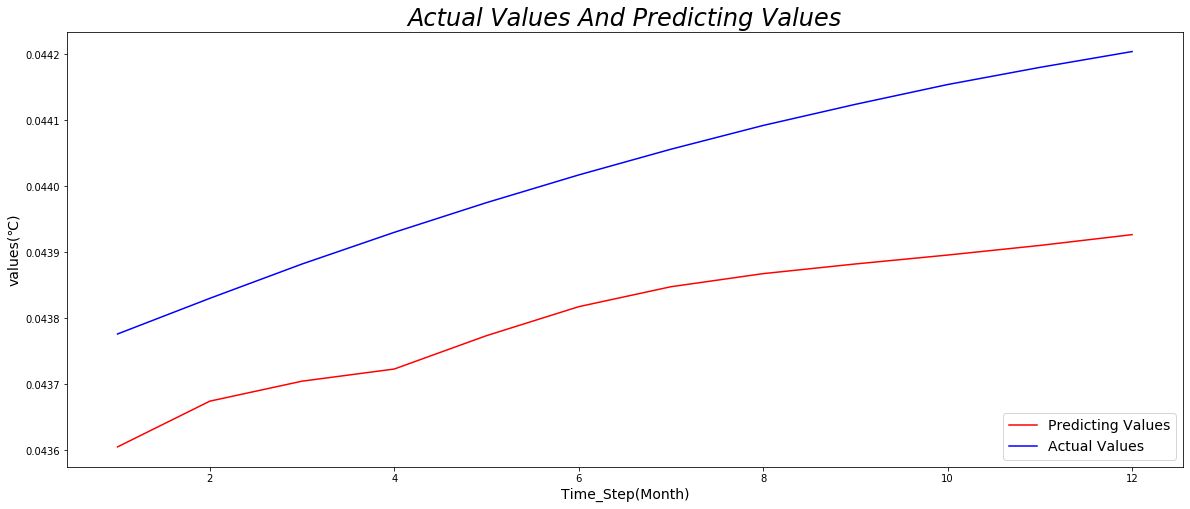

0      0.085791
1      0.085784
2      0.085777
3      0.085769
4      0.085762
5      0.085755
6      0.085747
7      0.085740
8      0.085733
9      0.085725
10     0.085718
11     0.085710
12     0.085703
13     0.085695
14     0.085687
15     0.085680
16     0.085672
17     0.085664
18     0.085657
19     0.085649
20     0.085641
21     0.085633
22     0.085625
23     0.085618
24     0.085610
25     0.085602
26     0.085594
27     0.085586
28     0.085578
29     0.085570
         ...   
666    0.078446
667    0.078438
668    0.078430
669    0.078422
670    0.078414
671    0.078405
672    0.078397
673    0.078389
674    0.078381
675    0.078373
676    0.078365
677    0.078357
678    0.078349
679    0.078341
680    0.078334
681    0.078326
682    0.078318
683    0.078310
684    0.078302
685    0.078295
686    0.078287
687    0.078279
688    0.078272
689    0.078264
690    0.078256
691    0.078249
692    0.078241
693    0.078234
694    0.078226
695    0.078219
Name: f8, Length: 696, d

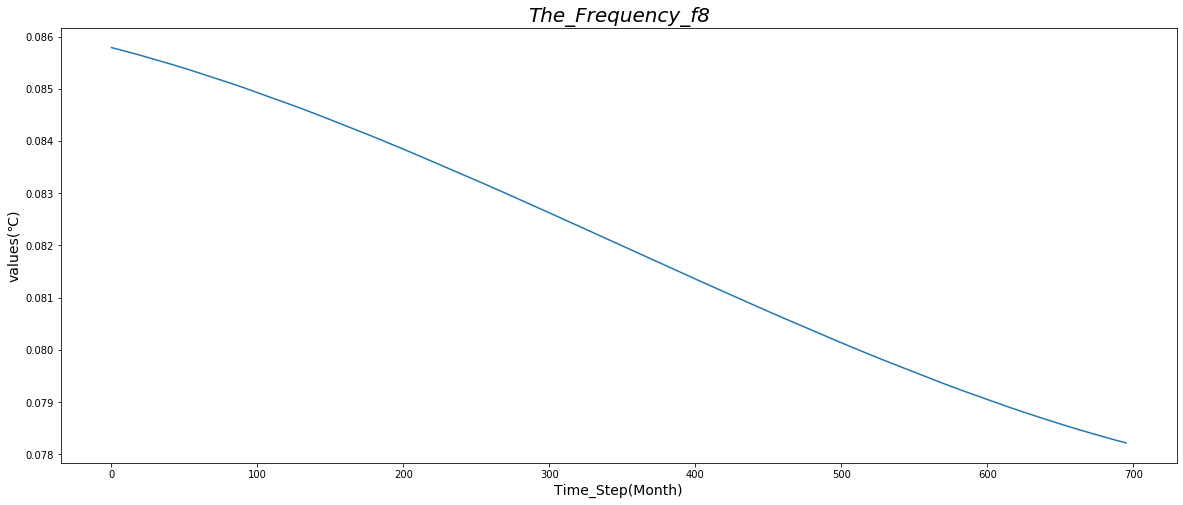

[[[0.085791]
  [0.085784]
  [0.085777]
  [0.085769]
  [0.085762]
  [0.085755]
  [0.085747]
  [0.08574 ]
  [0.085733]
  [0.085725]
  [0.085718]
  [0.08571 ]]

 [[0.085703]
  [0.085695]
  [0.085687]
  [0.08568 ]
  [0.085672]
  [0.085664]
  [0.085657]
  [0.085649]
  [0.085641]
  [0.085633]
  [0.085625]
  [0.085618]]

 [[0.08561 ]
  [0.085602]
  [0.085594]
  [0.085586]
  [0.085578]
  [0.08557 ]
  [0.085562]
  [0.085554]
  [0.085545]
  [0.085537]
  [0.085529]
  [0.085521]]

 [[0.085513]
  [0.085504]
  [0.085496]
  [0.085488]
  [0.085479]
  [0.085471]
  [0.085463]
  [0.085454]
  [0.085446]
  [0.085437]
  [0.085429]
  [0.08542 ]]

 [[0.085411]
  [0.085403]
  [0.085394]
  [0.085386]
  [0.085377]
  [0.085368]
  [0.085359]
  [0.085351]
  [0.085342]
  [0.085333]
  [0.085324]
  [0.085315]]

 [[0.085306]
  [0.085297]
  [0.085289]
  [0.08528 ]
  [0.085271]
  [0.085262]
  [0.085252]
  [0.085243]
  [0.085234]
  [0.085225]
  [0.085216]
  [0.085207]]

 [[0.085198]
  [0.085188]
  [0.085179]
  [0.08517 ]


Epoch 1/200
 - 29s - loss: 6.1170e-04
Epoch 2/200
 - 5s - loss: 1.3326e-05
Epoch 3/200
 - 5s - loss: 6.6090e-06
Epoch 4/200
 - 5s - loss: 5.3743e-06
Epoch 5/200
 - 5s - loss: 5.2033e-06
Epoch 6/200
 - 5s - loss: 5.1657e-06
Epoch 7/200
 - 5s - loss: 5.0619e-06
Epoch 8/200
 - 5s - loss: 5.3271e-06
Epoch 9/200
 - 5s - loss: 5.3244e-06
Epoch 10/200
 - 5s - loss: 5.1236e-06
Epoch 11/200
 - 5s - loss: 5.1883e-06
Epoch 12/200
 - 5s - loss: 5.1379e-06
Epoch 13/200
 - 5s - loss: 5.1083e-06
Epoch 14/200
 - 5s - loss: 5.0074e-06
Epoch 15/200
 - 5s - loss: 5.3080e-06
Epoch 16/200
 - 5s - loss: 5.8401e-06
Epoch 17/200
 - 5s - loss: 5.0882e-06
Epoch 18/200
 - 5s - loss: 5.3077e-06
Epoch 19/200
 - 5s - loss: 5.0874e-06
Epoch 20/200
 - 5s - loss: 6.0128e-06
Epoch 21/200
 - 5s - loss: 5.4342e-06
Epoch 22/200
 - 5s - loss: 5.4558e-06
Epoch 23/200
 - 5s - loss: 4.9745e-06
Epoch 24/200
 - 5s - loss: 4.9522e-06
Epoch 25/200
 - 5s - loss: 5.1669e-06
Epoch 26/200
 - 5s - loss: 5.0671e-06
Epoch 27/200
 - 5s -

(55, 12)


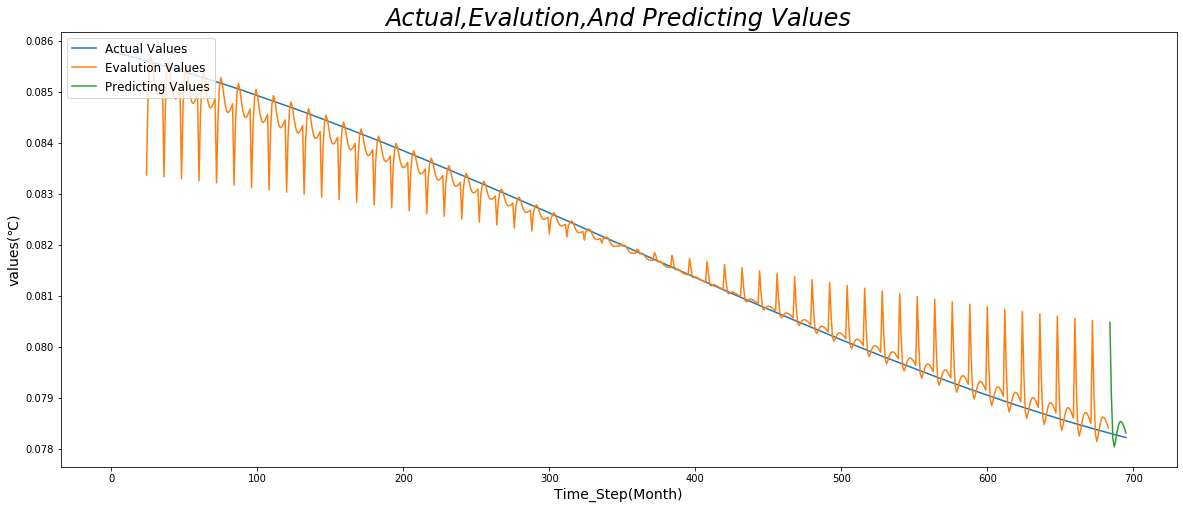

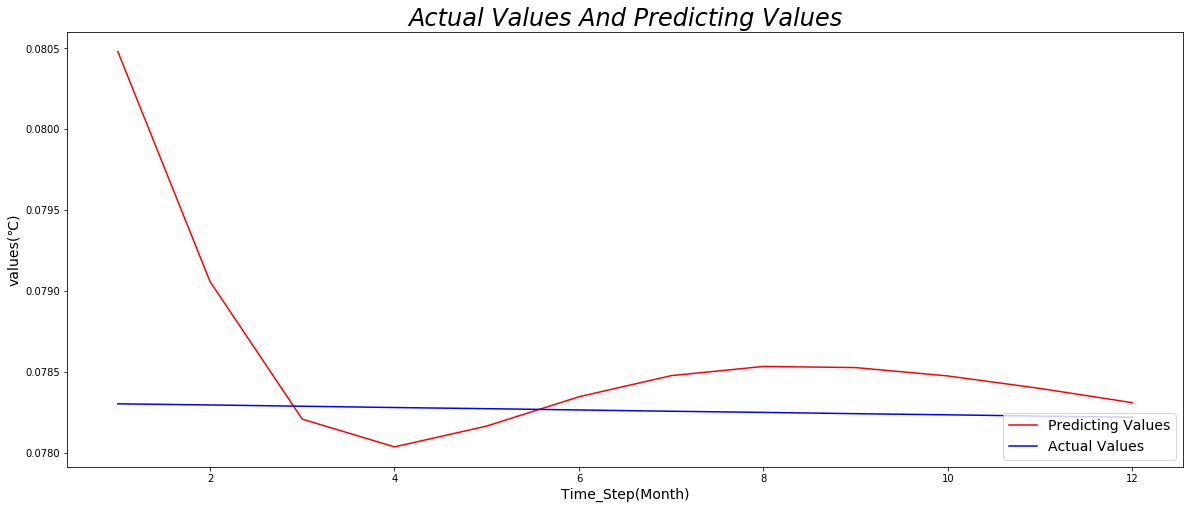

In [7]:
for i in range(9):
    index_name="f"+str(i)
    dataset = df[index_name][:-132]
    print (dataset)
    print (dataset.shape)

    plt.figure(figsize=(20,8))
    plt.plot(dataset)
    plt.title('The_Frequency_{0}'.format(index_name),fontstyle="italic",fontsize=20)    
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/The_Frequency_{0}'.format(index_name))
    plt.show() 
    
    #train, test = split_dataset(dataset.values)
    #train=train.reshape(train.shape[0],train.shape[1],1)
    #test=test.reshape(test.shape[0],train.shape[1],1)
    train, test = split_dataset(dataset.values)
    train=train.reshape(train.shape[0],train.shape[1],1)
    test=test.reshape(test.shape[0],train.shape[1],1)
    
    print (train)
    print (train[0].reshape(-1))
    print (test)
    print (test[0].reshape(-1))
    

    n_steps, n_length = 2, 12
    n_input = n_length * n_steps
    n_out=12
    
    train_x, train_y = to_supervised(train, n_input,n_out)

    print (train_x.shape)
    
    model=build_model(train_x,train_y,n_input,n_out,n_steps, n_length)
    score, scores,predictions = evaluate_model(train, test, n_input,n_steps, n_length)
    
    
    #trainPredict = model.predict(train)
    #print (predictions.reshape(-1))
    
    trainPredict=[]
    for index_train_predict in range(train.shape[0]-2):
        input_x=train.reshape(-1)[12*index_train_predict:(index_train_predict+2)*12]
        input_x = input_x.reshape((1, n_steps,1,n_length, 1))
        yhat = model.predict(input_x, verbose=0)
        trainPredict.append(yhat)

    trainPredict=np.array(trainPredict)
    trainPredict=trainPredict.reshape(trainPredict.shape[0],trainPredict.shape[2])
    print (trainPredict.shape)


    # shift train predictions for plotting
    trainPredictPlot = np.empty_like(dataset)
    trainPredictPlot[:] = np.nan
    #trainPredictPlot[12:len(trainPredict.reshape(-1))+12] = trainPredict.reshape(-1)
    trainPredictPlot[24:len(trainPredict.reshape(-1))+12*2] = trainPredict.reshape(-1)
    
# shift test predictions for plotting
    testPredictPlot = np.empty_like(dataset)
    testPredictPlot[:] = np.nan
    testPredictPlot[len(trainPredict.reshape(-1))+24:len(dataset)] = predictions.reshape(-1)
#testPredictPlot[len(trainPredict)+look_back+1:len(dataset)-1] = testPredict.reshape(-1)
# plot baseline and predictions

        
    plt.figure(figsize=(20,8))
    plt.title("Actual,Evalution,And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(dataset,label='Actual Values')
    plt.plot(trainPredictPlot,label='Evalution Values')
    plt.plot(testPredictPlot,label='Predicting Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=2,fontsize=12)
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_whole_result_{0}.png'.format(index_name))
    plt.show() 
    
    plt.figure(figsize=(20,8))
    index_start = np.array(range(1,13))
    plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
    plt.plot(index_start,predictions[0],color="red",label='Predicting Values')
    plt.plot(index_start,dataset[-12::].values,color="blue",label='Actual Values')
    plt.xlabel('Time_Step(Month)',fontsize=14)
    plt.ylabel('values(℃)',fontsize=14)
    plt.legend(loc=4,fontsize=14) 
    plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_predict_result_{0}.png'.format(index_name))
    plt.show() 
    
    dataset_in_one.append(dataset)
    train_prediciton_in_one.append(trainPredict.reshape(-1))
    real_in_one.append(dataset[-12::].values)
    prediction_in_one.append(predictions[0])


In [8]:
#backing up for the results
print (predictions[0])
print (real_in_one)
print (prediction_in_one)
back_real_in_one=real_in_one
back_prediction_in_one=prediction_in_one

[[0.08047868]
 [0.07905732]
 [0.07820722]
 [0.07803577]
 [0.07816454]
 [0.07834551]
 [0.078476  ]
 [0.07853285]
 [0.07852582]
 [0.07847416]
 [0.07839683]
 [0.07830901]]
[array([ 0.14502  , -0.073161 , -0.17033  , -0.17035  , -0.084327 ,
        0.0034646,  0.11313  ,  0.056119 ,  0.011284 , -0.050664 ,
        0.0348   ,  0.017427 ]), array([ 0.49968 ,  0.37993 ,  0.25298 ,  0.13992 ,  0.049156, -0.037781,
       -0.14373 , -0.28287 , -0.43679 , -0.57893 , -0.67655 , -0.68213 ]), array([ 0.40725 ,  0.35509 ,  0.28645 ,  0.20421 ,  0.11127 ,  0.01053 ,
       -0.095109, -0.20275 , -0.3095  , -0.41245 , -0.50871 , -0.59538 ]), array([-0.26139, -0.26348, -0.26278, -0.25944, -0.25362, -0.24547,
       -0.23515, -0.22282, -0.20865, -0.19282, -0.17548, -0.15681]), array([0.16965 , 0.16082 , 0.15179 , 0.14255 , 0.13311 , 0.12343 ,
       0.11353 , 0.1034  , 0.093041, 0.082458, 0.071655, 0.060635]), array([-0.16308, -0.16236, -0.16156, -0.16068, -0.15973, -0.15871,
       -0.15761, -0.15644, -

In [9]:
true_values=np.zeros((12,1))

for i in range(len(prediction_in_one)):
 
    print ("observe value:{0}".format(real_in_one[i]))
    #print (np.array(real_in_one[i]).reshape(12,1))
    true_values=true_values+np.array(real_in_one[i].reshape(12,1))
    print (true_values)
    round_true_values=np.round(true_values,2)
    print (round_true_values)
    
    print ("-----------------------------------")

observe value:[ 0.14502   -0.073161  -0.17033   -0.17035   -0.084327   0.0034646
  0.11313    0.056119   0.011284  -0.050664   0.0348     0.017427 ]
[[ 0.14502  ]
 [-0.073161 ]
 [-0.17033  ]
 [-0.17035  ]
 [-0.084327 ]
 [ 0.0034646]
 [ 0.11313  ]
 [ 0.056119 ]
 [ 0.011284 ]
 [-0.050664 ]
 [ 0.0348   ]
 [ 0.017427 ]]
[[ 0.15]
 [-0.07]
 [-0.17]
 [-0.17]
 [-0.08]
 [ 0.  ]
 [ 0.11]
 [ 0.06]
 [ 0.01]
 [-0.05]
 [ 0.03]
 [ 0.02]]
-----------------------------------
observe value:[ 0.49968   0.37993   0.25298   0.13992   0.049156 -0.037781 -0.14373
 -0.28287  -0.43679  -0.57893  -0.67655  -0.68213 ]
[[ 0.6447   ]
 [ 0.306769 ]
 [ 0.08265  ]
 [-0.03043  ]
 [-0.035171 ]
 [-0.0343164]
 [-0.0306   ]
 [-0.226751 ]
 [-0.425506 ]
 [-0.629594 ]
 [-0.64175  ]
 [-0.664703 ]]
[[ 0.64]
 [ 0.31]
 [ 0.08]
 [-0.03]
 [-0.04]
 [-0.03]
 [-0.03]
 [-0.23]
 [-0.43]
 [-0.63]
 [-0.64]
 [-0.66]]
-----------------------------------
observe value:[ 0.40725   0.35509   0.28645   0.20421   0.11127   0.01053  -0.095109
 -

In [10]:
predicted_values=np.zeros((12))
print (predicted_values)
for i in range(len(prediction_in_one)):
    print ("the {0} frequence:".format(i))    
    print ("predicted_value:{0}".format(prediction_in_one[i].reshape(-1)))
    predicted_values = np.add(predicted_values, prediction_in_one[i].reshape(-1))
    print (predicted_values)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
the 0 frequence:
predicted_value:[ 0.08011208  0.0397761   0.02831616  0.00923877 -0.04531978 -0.07841782
 -0.02640045  0.05613175  0.06308004 -0.01209245 -0.06480503 -0.03113253]
[ 0.08011208  0.0397761   0.02831616  0.00923877 -0.04531978 -0.07841782
 -0.02640045  0.05613175  0.06308004 -0.01209245 -0.06480503 -0.03113253]
the 1 frequence:
predicted_value:[ 0.40624952  0.1896458  -0.09650353 -0.40653744 -0.6807125  -0.8469294
 -0.8553309  -0.6994708  -0.4278336  -0.12108012  0.15041864  0.34621802]
[ 0.48636161  0.22942189 -0.06818736 -0.39729867 -0.72603231 -0.92534719
 -0.88173134 -0.64333906 -0.36475354 -0.13317257  0.08561361  0.31508549]
the 2 frequence:
predicted_value:[ 0.3917127   0.2799395   0.1148929  -0.0554625  -0.23071355 -0.39250943
 -0.5361113  -0.66129047 -0.76973027 -0.8584308  -0.9176289  -0.9336973 ]
[ 0.8780743   0.5093614   0.04670554 -0.45276117 -0.95674585 -1.31785662
 -1.41784263 -1.30462953 -1.13448381 -0.99160337 -0.8320

[[ 0.7]
 [ 0.3]
 [ 0. ]
 [-0.2]
 [-0.3]
 [-0.4]
 [-0.5]
 [-0.8]
 [-1.1]
 [-1.4]
 [-1.5]
 [-1.6]]
[ 0.53161026  0.15571323 -0.31338691 -0.81301958 -1.31568894 -1.67300217
 -1.76592296 -1.64198142 -1.45771461 -1.29824159 -1.12097358 -0.89038073]


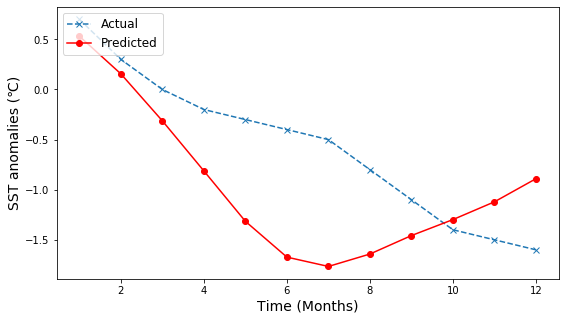

In [11]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),marker="x",linestyle='--',label='Actual')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')

plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 


No handles with labels found to put in legend.


[[ 0.7]
 [ 0.3]
 [ 0. ]
 [-0.2]
 [-0.3]
 [-0.4]
 [-0.5]
 [-0.8]
 [-1.1]
 [-1.4]
 [-1.5]
 [-1.6]]
[ 0.53161026  0.15571323 -0.31338691 -0.81301958 -1.31568894 -1.67300217
 -1.76592296 -1.64198142 -1.45771461 -1.29824159 -1.12097358 -0.89038073]


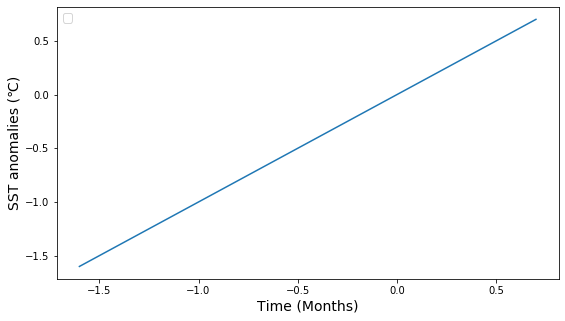

In [12]:
import os
print (round_true_values)
print (predicted_values)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(9,5))
index_start = np.array(range(1,13))
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(round_true_values.reshape(-1),round_true_values.reshape(-1))
#plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='Predicted')
#plt.scater(predicted_values.reshape(-1))
plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('SST anomalies (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result1.png')
plt.show() 

In [13]:
from sklearn import metrics
mae_12=metrics.mean_absolute_error(round_true_values,predicted_values)
print ("The Mean Absolute Errors between actual values and predicted values in 12 months is:{0}".format(np.round(mae_12,4)))

mse_12=metrics.mean_squared_error(round_true_values,predicted_values)
print ("The Mean Squared Errors between actual values and predicted values in 12 months is:{0}".format(np.round(mse_12,4)))

rmse_12=np.sqrt(metrics.mean_squared_error(round_true_values,predicted_values)) 
print ("The Root Mean Squared Errors between actual values and predicted values in 12 months is:{0}".format(np.round(rmse_12,4)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_12=mean_absolute_percentage_error(round_true_values,predicted_values) 
print ("The Mean Absolute Percentage Errors between actual values and predicted values in 12 months is:{0}%".format(np.round(mape_12,4)))

r2_socre=metrics.r2_score(round_true_values,predicted_values)
print ("The R2 Scores between actual values and predicted values in 12 months is:{0}".format(np.round(r2_socre,4)))


The Mean Absolute Errors between actual values and predicted values in 12 months is:0.1818
The Mean Squared Errors between actual values and predicted values in 12 months is:0.0393
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.1983
The Mean Absolute Percentage Errors between actual values and predicted values in 12 months is:73.5416%
The R2 Scores between actual values and predicted values in 12 months is:-5.8243


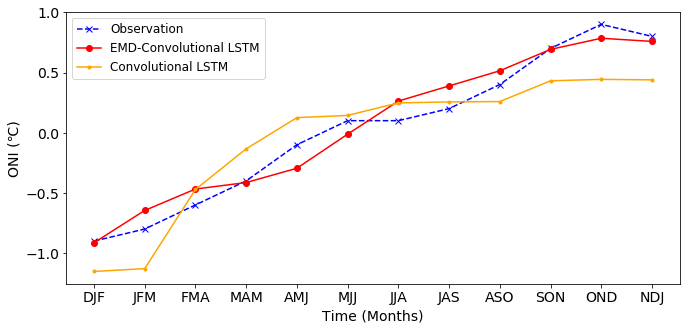

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import numpy as np
%matplotlib inline

normalized_lstms=np.array([-1.15227413,-1.12899268,-0.47112679,-0.13396825,0.12515147,0.1437145,0.247545,0.25556532,0.25881884,0.43107274,0.44317427,0.43884516])
predicted_values=np.array([-0.9138631,-0.64577143,-0.46778013,-0.41380659,-0.29520753,-0.01224175,0.26282753,0.38837113,0.51434888,0.69200458,0.78456772,0.7583482])
round_true_values=np.array([-0.9,-0.8,-0.6,-0.4,-0.1,0.1,0.1,0.2,0.4,0.7,0.9,0.8])

plt.figure(figsize=(11,5))
index_start = np.array(range(1,13))
index_start = ["DJF","JFM","FMA","MAM","AMJ","MJJ","JJA","JAS","ASO","SON","OND","NDJ"]

#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,round_true_values.reshape(-1),color="blue",marker="x",linestyle='--',label='Observation')
plt.plot(index_start,predicted_values.reshape(-1),color="red",marker="o",label='EMD-Convolutional LSTM')
plt.plot(index_start,normalized_lstms.reshape(-1),color="orange",marker=".",linestyle='-',label='Convolutional LSTM')

plt.tick_params(labelsize=14)


plt.xlabel('Time (Months)',fontsize=14,color="black")
plt.ylabel('ONI (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12) 

plt.savefig('12_months_SoloLstm_EMD_prediction/SoloLstm_EMD_the_final_predict_real_result.png')
plt.show() 

In [73]:
from sklearn import metrics
mae_12=metrics.mean_absolute_error(round_true_values,normalized_lstms)
print ("The Mean Absolute Errors between actual values and predicted values in 12 months is:{0}".format(np.round(mae_12,4)))

mse_12=metrics.mean_squared_error(round_true_values,normalized_lstms)
print ("The Mean Squared Errors between actual values and predicted values in 12 months is:{0}".format(np.round(mse_12,4)))

rmse_12=np.sqrt(metrics.mean_squared_error(round_true_values,normalized_lstms)) 
print ("The Root Mean Squared Errors between actual values and predicted values in 12 months is:{0}".format(np.round(rmse_12,4)))

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape_12=mean_absolute_percentage_error(round_true_values,normalized_lstms) 
print ("The Mean Absolute Percentage Errors between actual values and predicted values in 12 months is:{0}%".format(np.round(mape_12,4)))

r2_socre=metrics.r2_score(round_true_values,normalized_lstms)
print ("The R2 Scores between actual values and predicted values in 12 months is:{0}".format(np.round(r2_socre,4)))

The Mean Absolute Errors between actual values and predicted values in 12 months is:0.223
The Mean Squared Errors between actual values and predicted values in 12 months is:0.064
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.253
The Mean Absolute Percentage Errors between actual values and predicted values in 12 months is:64.2459%
The R2 Scores between actual values and predicted values in 12 months is:0.8139


[-0.9 -0.8 -0.6 -0.4 -0.1  0.1  0.1  0.2  0.4  0.7  0.9  0.8]
[-1.15227413 -1.12899268 -0.47112679 -0.13396825  0.12515147  0.1437145
  0.247545    0.25556532  0.25881884  0.43107274  0.44317427  0.43884516]


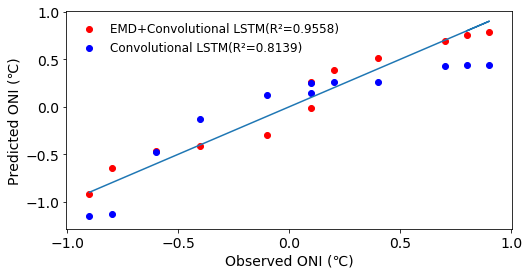

In [74]:
import os
print (round_true_values)
print (normalized_lstms)

if(os.path.exists('12_months_ConvLSTM_Encoder-Decoder Model_EMD')==False):
    os.makedirs('12_months_ConvLSTM_Encoder-Decoder Model_EMD')

plt.figure(figsize=(8,4))
index_start = np.array(range(1,13))
#plt.text(-0.9,0.7,r'R²=0.8139',fontsize=16)

plt.plot(round_true_values.reshape(-1),round_true_values.reshape(-1))
plt.scatter(round_true_values.reshape(-1),predicted_values,color="red",label='EMD+Convolutional LSTM(R²=0.9558)')
plt.scatter(round_true_values.reshape(-1),normalized_lstms,color="blue",label='Convolutional LSTM(R²=0.8139)')
plt.xlabel('Observed ONI (℃)',fontsize=14,color="black")
plt.ylabel('Predicted ONI (℃)',fontsize=14,color="black")

plt.legend(loc=2,fontsize=12,frameon=False) 
 
#for a, b in zip(round_true_values.reshape(-1), normalized_lstms):  
   # plt.text(a, np.round(b,4), (a,np.round(b,4)),ha='center', va='bottom', fontsize=10)  
 
plt.tick_params(labelsize=14)
plt.yticks([-1,-0.5,0.0,0.5,1.0])
plt.xticks([-1,-0.5,0.0,0.5,1.0])

plt.savefig('12_months_two_lstms_ConvLSTM_Encoder-Decoder Model_EMD/ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result1.png')
plt.show() 

In [75]:
from sklearn import metrics
compare_a=[]
compare_b=[]
compare_c=[]
mae_12_every=[]
mae_12_every_c=[]
for i in range(len(round_true_values)):
     a_window=round_true_values[i]
     b_window=predicted_values[i]
     c_window=normalized_lstms[i]
     compare_a.append(a_window)
     compare_b.append(b_window)
     compare_c.append(c_window)
     mae_12=metrics.mean_absolute_error(compare_a,compare_b)
     mae_12_every.append(mae_12)
    
     mae_12_c=metrics.mean_absolute_error(compare_a,compare_c)
     mae_12_every_c.append(mae_12_c)
     #print ("The Mean Absolute Errors between actual values and predicted values in 12 months is:{0}".format(np.round(mae_12,4)))
     print ("The Mean Absolute Errors between actual values and predicted values in 12 months is:{0}".format(np.round(mae_12_c,4)))

The Mean Absolute Errors between actual values and predicted values in 12 months is:0.2523
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.2906
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.2367
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.244
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.2403
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.2075
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.1989
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.181
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.1766
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.1858
The Mean Absolute Errors between actual values and predicted values in 12 months is:0.2105
T

In [76]:
from sklearn import metrics
compare_a=[]
compare_b=[]
compare_c=[]
rmse_12_every=[]
rmse_12_every_c=[]
for i in range(len(round_true_values)):
     a_window=round_true_values[i]
     b_window=predicted_values[i]
     c_window=normalized_lstms[i]
        
     compare_a.append(a_window)
     compare_b.append(b_window)
     compare_c.append(c_window)
     #print (compare_b)
     #print (compare_c)
     rmse_12=np.sqrt(metrics.mean_squared_error(compare_a,compare_b)) 
     rmse_12_every.append(rmse_12)
     
     rmse_12_c=np.sqrt(metrics.mean_squared_error(compare_a,compare_c)) 
     rmse_12_every_c.append(rmse_12_c)
     
     #print ("The Root Mean Squared Errors between actual values and predicted values in 12 months is:{0}".format(np.round(rmse_12,4)))
     print ("The Root Mean Squared Errors between actual values and predicted values in 12 months is:{0}".format(np.round(rmse_12_c,4)))

The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.2523
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.2932
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.2507
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.2546
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.249
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.228
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.2183
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.2052
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.1991
The Root Mean Squared Errors between actual values and predicted values in 12 months is:0.2071
The Root Mean Squared Errors between actual values a

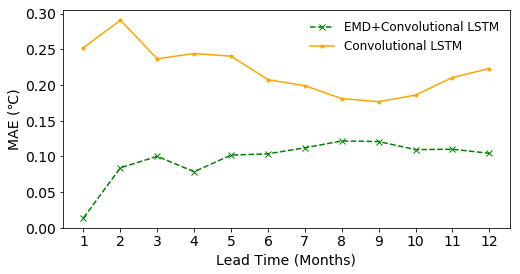

In [65]:
plt.figure(figsize=(8,4))
index_start = np.array(range(1,13))
#index_start = ["DJF","JFM","FMA","MAM","AMJ","MJJ","JJA","JAS","ASO","SON","OND","NDJ"," DJF "," JFM "]
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)
plt.plot(index_start,mae_12_every,color="g",marker="x",linestyle='--',label='EMD+Convolutional LSTM')
plt.plot(index_start,mae_12_every_c,color="orange",marker=".",linestyle='-',label='Convolutional LSTM')

plt.xlabel('Lead Time (Months)',fontsize=14,color="black")
plt.ylabel('MAE (℃)',fontsize=14,color="black")
plt.xticks(index_start)
plt.legend(loc=1,fontsize=12,frameon=False) 
plt.tick_params(labelsize=14)
plt.savefig('12_months_ConvLSTM_Encoder-Decoder Model_EMD/MAE_ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show() 

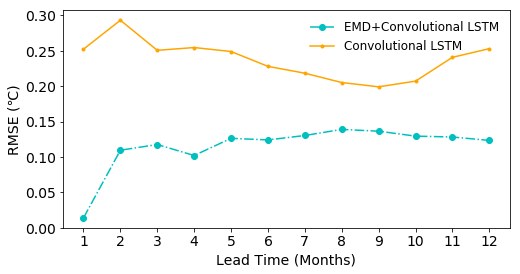

In [66]:
plt.figure(figsize=(8,4))
index_start = np.array(range(1,13))
#index_start = ["DJF","JFM","FMA","MAM","AMJ","MJJ","JJA","JAS","ASO","SON","OND","NDJ"," DJF "," JFM "]
#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)

plt.plot(index_start,rmse_12_every,color="c",marker="o",linestyle='-.',label='EMD+Convolutional LSTM')
plt.plot(index_start,rmse_12_every_c,color="orange",marker=".",linestyle='-',label='Convolutional LSTM')

plt.xlabel('Lead Time (Months)',fontsize=14,color="black")
plt.ylabel('RMSE (℃)',fontsize=14,color="black")
plt.xticks(index_start)
plt.legend(loc='upper right',fontsize=12,frameon=False) 
plt.tick_params(labelsize=14)
plt.savefig('12_months_ConvLSTM_Encoder-Decoder Model_EMD/RMSE_ConvLSTM Encoder-Decoder Model _EMD_the_final_predicting_and_real_result.png')
plt.show()


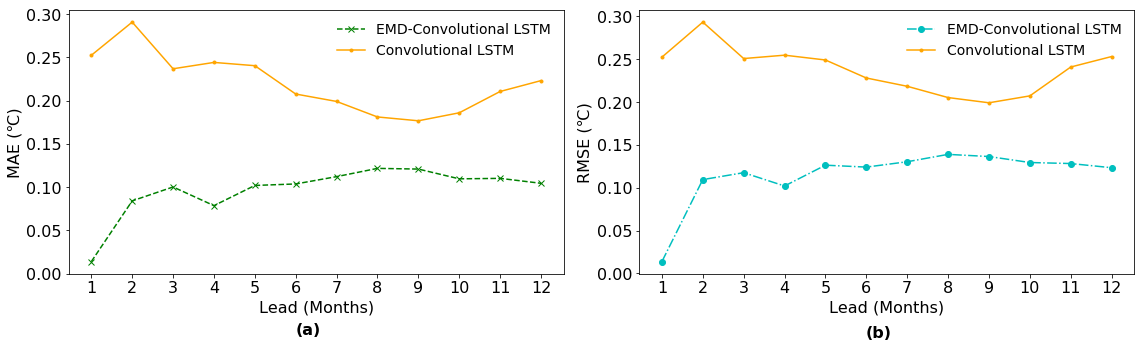

In [85]:
import matplotlib.pyplot as plt
from matplotlib.transforms import BlendedGenericTransform


index_start = np.array(range(1,13))
# mode 01 from one case
fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))

#plt.title("Actual Values And Predicting Values",fontstyle="italic",fontsize=24)

axes[0].plot(index_start,mae_12_every,color="g",marker="x",linestyle='--',label='EMD-Convolutional LSTM')
axes[0].plot(index_start,mae_12_every_c,color="orange",marker=".",linestyle='-',label='Convolutional LSTM')

axes[0].set_xlabel('Lead (Months)',fontsize=16,color="black")
axes[0].set_ylabel('MAE (℃)',fontsize=16,color="black")
axes[0].set_xticks(index_start, minor=False)
axes[0].tick_params(labelsize=16)
axes[0].legend(loc=1,fontsize=14,frameon=False) 

    
# mode 02 from one case
axes[1].plot(index_start,rmse_12_every,color="c",marker="o",linestyle='-.',label='EMD-Convolutional LSTM')
axes[1].plot(index_start,rmse_12_every_c,color="orange",marker=".",linestyle='-',label='Convolutional LSTM')

axes[1].set_xlabel('Lead (Months)',fontsize=16,color="black")
axes[1].set_ylabel('RMSE (℃)',fontsize=16,color="black")
axes[1].tick_params(labelsize=16)
axes[1].set_xticks(index_start, minor=False)
axes[1].legend(loc='upper right',fontsize=14,frameon=False) 
axes[1].tick_params(labelsize=16)

axes[0].text(6.3, -.07,"(a)", ha='center',fontsize=16,weight='bold')
axes[1].text(6.3, -.075,"(b)", ha='center',fontsize=16,weight='bold')

plt.gcf().subplots_adjust(bottom=0.1)
plt.tight_layout()

plt.savefig('2222.png')